# Data Cleaning & Preprocessing

This notebook performs deterministic, repeatable cleaning steps and writes intermediate CSV artifacts to `../data/interim/` for later merging and ingestion.

### Goals
- Normalize column names and canonicalize schemas for each raw file.
- Fix obvious data-type issues and suspicious/invalid/outlier values.
- Remove duplicates and aggregate where appropriate (price table).
- Standardize and probabilistically impute user locations.
### Notes
- Run cells end-to-end in a kernel with sufficient memory for the smaller datasets; price_books is chunked to avoid excessive memory use.
- The cleaning uses helper functions already defined earlier in this notebook (apply_column_map, normalize_colname, expand_and_standardize_locations, probabilistic_location_imputation, among others).

---

## 0. Cleaning & Preprocessing Setup

In [1]:
# Import all necessary libraries
from pathlib import Path
import re 
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm.auto import tqdm  # For progress bars
from collections import Counter
import unicodedata
from rapidfuzz import process, fuzz
import pycountry
import geonamescache
import math
import random
from typing import Optional, Union
import warnings
from collections import Counter
from rapidfuzz import fuzz, process
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time

# Set matplotlib backend for Jupyter notebooks
%matplotlib inline

In [2]:
def _compute_relative_target_dir(target_dir: Path) -> str:
    try:
        td = target_dir.resolve()
        # Project root is one level above 'notebooks' directory
        for p in td.parents:
            if (p / "notebooks").exists():
                project_root = p
                break
        rel = "/" + project_root.name + "/" + td.relative_to(project_root).as_posix()
    except Exception:
        rel = target_dir.as_posix()
    return rel

# Create interim directory
interim_dir = Path("../data/interim")
interim_dir.mkdir(parents=True, exist_ok=True)
rel = _compute_relative_target_dir(interim_dir)
print(f"Interim folder: {rel}")

# --------------------- HELPER FUNCTIONS ---------------------
def normalize_colname(s):
    s = str(s).strip()
    s = s.replace('-', '_').replace(' ', '_')
    s = re.sub(r'\W', '', s) # remove non-alphanumeric characters except underscore
    s = re.sub(r'__+', '_', s)
    return s.lower()

def apply_column_map(df, col_map=None, drop_cols=None, keep_only=None):
    # normalize existing column names
    df = df.rename(columns={c: normalize_colname(c) for c in df.columns})
    # apply mapping for known variants
    if col_map:
        col_map_norm = {normalize_colname(k): v for k,v in col_map.items()}
        df = df.rename(columns=col_map_norm)
    # optionally drop unwanted
    if drop_cols:
        df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    # optionally keep only a subset (after mapping)
    if keep_only:
        keep = [c for c in keep_only if c in df.columns]
        df = df[keep].copy()
    return df

# --------------------- DATA ORGANIZATION ---------------------

# Example mapping dictionaries (including comments about additional processing needed,
# synthethic data to be added later and overall data structure information)
main_books_map = {
    'isbn': 'isbn',
    'book_title': 'title',
    'book_author': 'author',
    'publisher': 'publisher',
    'year_of_publication': 'publication_year'
    # image_url s/m/l
}

# users columns = [
#   'user_id', 
#   'location', 
#   'age'
# ]
# we also want to have:
# 'location' -> 'city', 'region' , 'country'
# 'loc_latitude' , 'loc_longitude'  # derived from 'location' using geocoding API (geopy or similar)
# 'gender' ('male', 'female', 'non_binary') # assigned randomly with a certain distribution
# perhaps include in the database a comment that says this is a synthetic variable
# 'age_group' ('child', 'teen', 'young_adult', 'adult_25_35', 'adult_36_45', 'adult_46_55', 'adult_56_65', 'senior_66_plus')
# for age or location where the data is missing or invalid we assign synthetic values based on overall distributions and include a flag
# like 'is_synthetic_age', 'is_synthetic_location' boolean columns

ratings_map = {
    'user_id': 'user_id',
    'isbn': 'isbn',
    'book_rating': 'rating'
}

sec_books_map = {
    'isbn': 'isbn',
    'title': 'title',
    # 'author': 'author', # be careful this at the momment is not a string, but an array of authors
    # we might want to include authors from this variable to the original's author variable if missing
    'publisher': 'publisher',
    # publishedDate is to be removed and replaced with 'publication_year' extracted from it
    'categories': 'genre', # we will keep this as genre and expand to include 
    # self determined genre hierarchy later to have root genre and direct parent genre 
    # these might be used when recommending to give the user some more info
    'description': 'description',
    'info_link': 'info_link',
    'image': 'image_alternative', # to avoid confusion with main image urls
    'preview_link': 'preview_link'

}

# NOTE: Choose hybrid (MySQL core variables with no missing values + Mongo enrichment to keep extra 
# information on books that have this extra info and avoid duplication and sparse data) if you expect large, 
# sparse long-text or arrays and want flexible updates.


price_map = {
    'id': 'isbn',
    'title': 'title',
    'price': 'price_usd' # because of data provenance and observed values in 
    # the context, we assumed the currency is USD
    # we might want to create price_cat later based on price ranges like:
    # 'price_cat': 'cheap' (0-10), 'normal' (10-30), 'expensive' (30+), or something different
}

Interim folder: /book_rec_project/data/interim



---

## 1. Cleaning Main Books Dataset

In [17]:
print("Cleaning main_books.csv -> books_cleaned.csv\n")
books_path = Path("../data/raw/main_books.csv")
if not books_path.exists():
    raise FileNotFoundError(f"{books_path} not found")

df_books = pd.read_csv(books_path, sep=",", low_memory=False)
print(f"Current columns in main_books.csv: {df_books.columns.tolist()}")
df_books = apply_column_map(df_books, main_books_map)
print(f"Columns after applying main_books_map: {df_books.columns.tolist()}")

# canonical column names expected: isbn, title, author, publisher, publication_year
# publication_year -> numeric
# Coerce to numeric then cast to a smaller nullable integer dtype (Int16) to save memory
# Int16 is safe for year values (range ~1000-9999) and preserves NA via pandas nullable integer
df_books["publication_year"] = pd.to_numeric(df_books["publication_year"], errors="coerce").astype("Int16")

# Flag obviously outlier values, that might be removed after merging and not 
# finding a valid match form the sec book dataset
# Identify suspicious years (e.g., before 1450 - Gutenberg printing press, or after current year)
current_year = time.localtime().tm_year
suspicious_mask = (df_books["publication_year"].notna()) & ((df_books["publication_year"] < 1450) | (df_books["publication_year"] > current_year))
# Assign all the suspecious year values to missing data for further check with secundary dataset
df_books.loc[suspicious_mask, "publication_year"] = pd.NA

# deduplicate by ISBN if needed: keep first non-null row per ISBN
duplicate_count = df_books.duplicated(subset=["isbn"]).sum() if "isbn" in df_books.columns else print("No collumn named 'isbn' found for deduplication")
if duplicate_count == 0:
    print("\nThe dataset has no duplicates based on 'isbn'!")
else:
    before = len(df_books)
    df_books = df_books.drop_duplicates(subset=["isbn"], keep="first").reset_index(drop=True)
    print(f"\nDeduplicated books: {before} -> {len(df_books)}")

print("\nDisplaying first 5 rows of cleaned books dataframe:")
display(df_books.head(5))
missing_pub_year_count = df_books["publication_year"].isna().sum()
print(f"Number of rows with missing publication_year: {missing_pub_year_count} ( {missing_pub_year_count / len(df_books) * 100:.2f}% total)")
# Save
books_out = interim_dir / "books_cleaned.csv"
book_rel = _compute_relative_target_dir(books_out)
df_books.to_csv(books_out, index=False, encoding="utf-8")
print(f"\nSaved: {book_rel} ({len(df_books):,} rows)")

Cleaning main_books.csv -> books_cleaned.csv

Current columns in main_books.csv: ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
Columns after applying main_books_map: ['isbn', 'title', 'author', 'publication_year', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l']

The dataset has no duplicates based on 'isbn'!

Displaying first 5 rows of cleaned books dataframe:


,isbn,title,author,publication_year,publisher,image_url_s,image_url_m,image_url_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Number of rows with missing publication_year: 4635 ( 1.71% total)

Saved: /book_rec_project/data/interim/books_cleaned.csv (271,360 rows)



---

## 2. Cleaning secundary books dataset

In [18]:
print("Merging the price data with book metadata to solve isbn missing values in sec_books.csv\n")
print("\nLoading sec_books.csv:\n")
sec_path = Path("../data/raw/sec_books.csv")
price_path = Path("../data/raw/price_books.csv")
if not price_path.exists():
    print(f"Warning: {price_path} not found.")
if not sec_path.exists():
    print(f"Warning: {sec_path} not found.")

# Load sec_books
df_sec = pd.read_csv(sec_path, sep=",", low_memory=False)
print(f"Current columns in sec_books.csv: {df_sec.columns.tolist()}")
df_sec = apply_column_map(df_sec, sec_books_map, drop_cols=['ratingscount'])
print(f"Columns after applying sec_books_map: {df_sec.columns.tolist()}")

print("\nDisplaying first 5 rows of cleaned sec_books dataframe:")
display(df_sec.head(5))

# Batch loading price_books
# Define columns to keep (filter early to save memory)
columns_to_keep = ['Id', 'Title', 'Price']
batch_size = 30000

# Initialize list to store filtered chunks
price_chunks = []
total_rows_processed = 0
total_rows_kept = 0

print("Trying batch loading the price_books.csv")
try:
    # First pass: count total chunks for progress bar
    total_chunks = sum(1 for _ in pd.read_csv(
        "../data/raw/price_books.csv",
        sep=',',
        usecols=['Id'],  # Just one column for speed
        chunksize=batch_size,
        low_memory=False
    ))
    # Second pass: actual loading with progress bar
    chunk_iterator = pd.read_csv(
        "../data/raw/price_books.csv", 
        sep=',',
        usecols=columns_to_keep,
        chunksize=batch_size,
        low_memory=False
    )
    
    # Wrap with tqdm for progress bar
    for chunk in tqdm(chunk_iterator, total=total_chunks, desc="Processing chunks", unit="chunk"):
        # Drop rows with missing Id (critical field)
        chunk_clean = chunk.dropna(subset=['Id'])
        
        # Track stats
        total_rows_processed += len(chunk)
        total_rows_kept += len(chunk_clean)
        
        # Add to list
        price_chunks.append(chunk_clean)
    
    # Concatenate all chunks
    df_price_books = pd.concat(price_chunks, ignore_index=True)
    # Summary
    print(f"\n{'='*60}")
    print("✓ Loading Complete!")
    print(f"{'='*60}")
    print(f"  Total rows read:      {total_rows_processed:,}")
    print(f"  Rows with valid data: {total_rows_kept:,}")
    print(f"  Rows dropped:         {total_rows_processed - total_rows_kept:,} ({(total_rows_processed - total_rows_kept) / total_rows_processed * 100:.2f}%)")
    print(f"{'='*60}\n")
    
except Exception as e:
    print(f"\n✗ Error loading file: {str(e)}")
    df_price_books = pd.DataFrame()  # Empty fallback

if df_price_books is not None and not df_price_books.empty:
    # Apply price mapping
    print(f"Current columns in price_books.csv: {df_price_books.columns.tolist()}")
    df_price_books = apply_column_map(df_price_books, price_map)
    print(f"Columns after applying price_map: {df_price_books.columns.tolist()}")

Merging the price data with book metadata to solve isbn missing values in sec_books.csv


Loading sec_books.csv:

Current columns in sec_books.csv: ['Title', 'description', 'authors', 'image', 'previewLink', 'publisher', 'publishedDate', 'infoLink', 'categories', 'ratingsCount']
Columns after applying sec_books_map: ['title', 'description', 'authors', 'image_alternative', 'previewlink', 'publisher', 'publisheddate', 'infolink', 'genre']

Displaying first 5 rows of cleaned sec_books dataframe:


,title,description,authors,image_alternative,previewlink,publisher,publisheddate,infolink,genre
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels']
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography']
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion']
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction']
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN


Trying batch loading the price_books.csv


Processing chunks:   0%|          | 0/100 [00:00<?, ?chunk/s]


✓ Loading Complete!
  Total rows read:      3,000,000
  Rows with valid data: 3,000,000
  Rows dropped:         0 (0.00%)

Current columns in price_books.csv: ['Id', 'Title', 'Price']
Columns after applying price_map: ['isbn', 'title', 'price_usd']


### Normalize `publishedDate` → `publication_year`

We extract a 4-digit year when possible (covers "2000", "2014-05-15", "2022-06-22T22:59:00Z", "1963*", "1994-02", "1990-1992"), otherwise fall back to pandas.to_datetime. Years outside a reasonable range (before 1450 or after current year) are treated as missing. We keep a small provenance column (source) and a suspicious flag to review borderline cases.

In [19]:
# Column to inspect
date_col = 'publisheddate'

# Basic diagnostics
print(f"Original dtype for '{date_col}': {df_sec[date_col].dtype}")
print(f"Unique '{date_col}' formats and values:")
unique_published_dates = df_sec[date_col].dropna().astype(str).unique()
display(pd.Series(unique_published_dates))

# Helpers
year_regex = re.compile(r'(?<!\d)(\d{4})(?!\d)')  # first standalone 4-digit group

def extract_year_and_source(value):
    """Return tuple (year_or_pdNA, source_str).
    Sources: 'regex', 'pd_to_datetime', 'missing', 'empty', 'unparsable'
    """
    if value is None or (isinstance(value, float) and math.isnan(value)):
        return pd.NA, 'missing'
    s = str(value).strip()
    if s == '':
        return pd.NA, 'empty'

    # Try regex (covers things like "1963*", "1994-02", "1990-1992", "2022-06-22T...")
    m = year_regex.search(s)
    if m:
        try:
            y = int(m.group(1))
            if 1000 <= y <= 9999:
                return y, 'regex'
        except Exception:
            pass

    # Fallback: try pandas parsing (handles ISO-ish and partial dates)
    try:
        dt = pd.to_datetime(s, errors='coerce', dayfirst=False, yearfirst=True)
        if not pd.isna(dt):
            return int(dt.year), 'pd_to_datetime'
    except Exception:
        pass

    return pd.NA, 'unparsable'

def validate_year(y):
    """Return year if in sensible range [1450, current_year], else pd.NA."""
    try:
        if pd.isna(y):
            return pd.NA
        y = int(y)
        if 1450 <= y <= current_year:
            return y
    except Exception:
        pass
    return pd.NA

# Extract year + provenance into two columns
extracted = df_sec[date_col].apply(extract_year_and_source)
df_sec[['publication_year_raw', 'publication_year_source']] = pd.DataFrame(
    extracted.tolist(), index=df_sec.index
)

# Validate / clamp years and mark suspicious cases
df_sec['publication_year'] = df_sec['publication_year_raw'].apply(validate_year)
df_sec['publication_year_suspicious'] = (
    df_sec['publication_year_raw'].notna() & df_sec['publication_year'].isna()
)


valid_count = df_sec['publication_year'].notna().sum()
total = len(df_sec)
suspicious_count = df_sec['publication_year_suspicious'].sum()
print(f"\nValid publication_year: {valid_count:,} / {total:,} ({valid_count/total:.1%})")
print(f"Suspicious (extracted then dropped): {suspicious_count:,} ({suspicious_count/total:.1%})")
print(f"Missing publisheddate field: {(df_sec[date_col].isna().sum()):,} ({df_sec[date_col].isna().mean():.1%})")

# Inspection helper (compact, reproducible sampling)
def inspect_date_extraction(df, date_col='publisheddate', preview_cols=None, n_head=10, n_samples=5):
    if preview_cols is None:
        preview_cols = ['title', date_col, 'publication_year_raw', 'publication_year_source']

    print("\n-- source distribution --")
    display(df['publication_year_source'].value_counts())
    print(f"Total rows: {len(df):,}")

    # Suspicious (extracted raw present but final year dropped)
    sus_mask = df['publication_year_suspicious'].fillna(False).astype(bool)
    print(f"\nSuspicious rows (extracted then filled with NaN): {sus_mask.sum():,}")
    if sus_mask.any():
        print("'publication_year_raw' values for suspicious rows:")
        display(df.loc[sus_mask, 'publication_year_raw'].astype(str).value_counts())

    # Unparsable rows
    unpars_mask = df['publication_year_source'] == 'unparsable'
    print(f"\nUnparsable rows: {unpars_mask.sum():,}")
    if unpars_mask.any():
        print("All raw data for unparsable rows:")
        display(df.loc[unpars_mask, date_col].astype(str).value_counts())
        print(f"Random {min(n_samples, unpars_mask.sum())} unparsable examples:")
        display(df.loc[unpars_mask, preview_cols].sample(min(n_samples, unpars_mask.sum()), random_state=0))

    # Missing final publication_year (any source)
    missing_mask = df['publication_year'].isna()
    print(f"\nRows with final publication_year missing: {missing_mask.sum():,}")
    if missing_mask.any():
        print("\nSamples stratified by publication_year_source (up to 5 per source):")
        sources = df.loc[missing_mask, 'publication_year_source'].fillna('NA').unique()
        for s in sources:
            subset = df.loc[missing_mask & (df['publication_year_source'].fillna('NA') == s)]
            cnt = len(subset)
            print(f"\nSource='{s}': {cnt:,} rows. Top {n_head} raw tokens:")
            display(subset[date_col].astype(str).value_counts().head(n_head))
            display(subset[preview_cols].sample(min(n_samples, cnt), random_state=0))

    # Combined problematic tokens
    tok_sus = df.loc[sus_mask, 'publication_year_raw'].astype(str).value_counts().rename('suspicious_count')
    tok_unp = df.loc[unpars_mask, date_col].astype(str).value_counts().rename('unparsable_count')
    problem_tokens = pd.concat([tok_sus, tok_unp], axis=1).fillna(0).astype(int).sort_values(
        ['suspicious_count', 'unparsable_count'], ascending=False
    )
    if not problem_tokens.empty:
        print("\nCombined problematic tokens (suspicious / unparsable) — top 50:")
        display(problem_tokens.head(50))

    print("\nInspection finished.")

# Run inspection
inspect_date_extraction(
    df_sec,
    date_col=date_col,
    preview_cols=['title', date_col, 'publication_year_raw', 'publication_year_source', 'publisher'],
    n_head=10,
    n_samples=5
)

# Create a compact dataset and show missing-data summary
print("\nCreating compact preview dataframe:")
keep_cols = ['title', 'publication_year', 'description', 'authors', 'publisher', 'genre', 'image_alternative', 'previewlink', 'infolink']
df_sec_year = df_sec[keep_cols].copy()

print("Preview of compact dataframe:")
display(df_sec_year.head(10))

print("\nMissing data distribution in compact dataframe:")
missing_counts = df_sec_year.isna().sum()
missing_pct = (missing_counts / len(df_sec_year) * 100).round(2)
missing_df = pd.DataFrame({"missing_count": missing_counts, "missing_pct": missing_pct}).sort_values("missing_count", ascending=False)
display(missing_df)


Original dtype for 'publisheddate': object
Unique 'publisheddate' formats and values:


0              1996
1        2005-01-01
2              2000
3           2005-02
4        2003-03-01
            ...    
11577    1987-12-17
11578    1969-02-07
11579    1984-06-30
11580    1999-04-10
11581    1977-08-12
Length: 11582, dtype: object


Valid publication_year: 186,960 / 212,404 (88.0%)
Suspicious (extracted then dropped): 2 (0.0%)
Missing publisheddate field: 25,305 (11.9%)

-- source distribution --


publication_year_source
regex         186962
missing        25305
unparsable       137
Name: count, dtype: int64

Total rows: 212,404

Suspicious rows (extracted then filled with NaN): 2
'publication_year_raw' values for suspicious rows:


publication_year_raw
1016    1
2030    1
Name: count, dtype: int64


Unparsable rows: 137
All raw data for unparsable rows:


publisheddate
19??         45
199?         13
196?         11
197?         10
101-01-01     9
200?          7
198?          7
195?          6
192?          4
193?          4
190?          3
194?          3
20??          3
18??          2
189?          2
187?          2
191?          2
188?          2
16??          1
17??          1
Name: count, dtype: int64

Random 5 unparsable examples:


,title,publisheddate,publication_year_raw,publication_year_source,publisher
46034,Tesuji and Anti-Suji of Go (Sakata series),19??,<NA>,unparsable,NaN
9747,Taxes and Termites,196?,<NA>,unparsable,NaN
130468,Voices From The Edge,199?,<NA>,unparsable,NaN
124961,Do the Hokey Pokey,199?,<NA>,unparsable,NaN
79491,Getting by in Chinese/Book and 2 Audio Cassettes,19??,<NA>,unparsable,NaN



Rows with final publication_year missing: 25,444

Samples stratified by publication_year_source (up to 5 per source):

Source='missing': 25,305 rows. Top 10 raw tokens:


publisheddate
nan    25305
Name: count, dtype: int64

,title,publisheddate,publication_year_raw,publication_year_source,publisher
147834,Be dangerous on rock guitar,NaN,<NA>,missing,NaN
204514,The Book of the Dead Man,NaN,<NA>,missing,NaN
209339,Cup of Love: A Novel,NaN,<NA>,missing,NaN
77531,Musings of a mediocre gardener (Friends of Lin...,NaN,<NA>,missing,NaN
212215,Jimi Hendrix Experience - Smash Hits: Guitar P...,NaN,<NA>,missing,NaN



Source='unparsable': 137 rows. Top 10 raw tokens:


publisheddate
19??         45
199?         13
196?         11
197?         10
101-01-01     9
200?          7
198?          7
195?          6
192?          4
193?          4
Name: count, dtype: int64

,title,publisheddate,publication_year_raw,publication_year_source,publisher
46034,Tesuji and Anti-Suji of Go (Sakata series),19??,<NA>,unparsable,NaN
9747,Taxes and Termites,196?,<NA>,unparsable,NaN
130468,Voices From The Edge,199?,<NA>,unparsable,NaN
124961,Do the Hokey Pokey,199?,<NA>,unparsable,NaN
79491,Getting by in Chinese/Book and 2 Audio Cassettes,19??,<NA>,unparsable,NaN



Source='regex': 2 rows. Top 10 raw tokens:


publisheddate
1016-10-11    1
2030-12-31    1
Name: count, dtype: int64

,title,publisheddate,publication_year_raw,publication_year_source,publisher
98662,A Wealth of Wisdom: Legendary African American...,2030-12-31,2030,regex,Simon and Schuster
61054,MANSIONS OF DARKNESS,1016-10-11,1016,regex,Valancourt Books



Combined problematic tokens (suspicious / unparsable) — top 50:


,suspicious_count,unparsable_count
1016,1,0
2030,1,0
19??,0,45
199?,0,13
196?,0,11
197?,0,10
101-01-01,0,9
200?,0,7
198?,0,7
195?,0,6



Inspection finished.

Creating compact preview dataframe:
Preview of compact dataframe:


,title,publication_year,description,authors,publisher,genre,image_alternative,previewlink,infolink
0,Its Only Art If Its Well Hung!,1996,NaN,['Julie Strain'],NaN,['Comics & Graphic Novels'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,http://books.google.nl/books?id=DykPAAAACAAJ&d...
1,Dr. Seuss: American Icon,2005,Philip Nel takes a fascinating look into the k...,['Philip Nel'],A&C Black,['Biography & Autobiography'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,http://books.google.nl/books?id=IjvHQsCn_pgC&d...
2,Wonderful Worship in Smaller Churches,2000,This resource includes twelve principles in un...,['David R. Ray'],NaN,['Religion'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...
3,Whispers of the Wicked Saints,2005,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],iUniverse,['Fiction'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...
4,"Nation Dance: Religion, Identity and Cultural ...",2003,NaN,['Edward Long'],NaN,NaN,NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,http://books.google.nl/books?id=399SPgAACAAJ&d...
5,The Church of Christ: A Biblical Ecclesiology ...,1996,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],Wm. B. Eerdmans Publishing,['Religion'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,http://books.google.nl/books?id=kVqRaiPlx88C&d...
6,The Overbury affair (Avon),1960,NaN,['Miriam Allen De Ford'],NaN,NaN,NaN,http://books.google.nl/books?id=mHLTngEACAAJ&d...,http://books.google.nl/books?id=mHLTngEACAAJ&d...
7,A Walk in the Woods: a Play in Two Acts,1988,NaN,['Lee Blessing'],NaN,NaN,NaN,http://books.google.nl/books?id=6HDOwAEACAAJ&d...,http://books.google.nl/books?id=6HDOwAEACAAJ&d...
8,Saint Hyacinth of Poland,2009,The story for children 10 and up of St. Hyacin...,['Mary Fabyan Windeatt'],Tan Books & Pub,['Biography & Autobiography'],http://books.google.com/books/content?id=lmLqA...,http://books.google.nl/books?id=lmLqAAAACAAJ&d...,http://books.google.nl/books?id=lmLqAAAACAAJ&d...
9,Rising Sons and Daughters: Life Among Japan's ...,1995,Wardell recalls his experience as a foreign st...,['Steven Wardell'],Plympton PressIntl,['Social Science'],NaN,http://books.google.nl/books?id=rbLZugEACAAJ&d...,http://books.google.nl/books?id=rbLZugEACAAJ&d...



Missing data distribution in compact dataframe:


,missing_count,missing_pct
publisher,75886,35.73
description,68442,32.22
image_alternative,52075,24.52
genre,41199,19.40
authors,31413,14.79
publication_year,25444,11.98
previewlink,23836,11.22
infolink,23836,11.22
title,1,0.00


### Merge `df_sec_year` with `df_price_books` by title for further preprocessing


In [20]:
# Merge df_sec_year with df_price_books by a simple title key (no unicode normalization function)
# Use lowercased, stripped title as the join key (empty string for missing)
if 'df_price_books' not in globals() or df_price_books is None:
    df_price_books = pd.DataFrame(columns=['title','isbn','price_usd'])

df_price_books = df_price_books.copy()
df_sec_year = df_sec_year.copy()

# Ensure price numeric
if 'price_usd' in df_price_books.columns:
    df_price_books['price_usd'] = pd.to_numeric(df_price_books['price_usd'], errors='coerce')

# Simple title key: lower + strip (no unicode normalization / punctuation removal)
df_price_books['title_key'] = df_price_books['title'].astype(str).str.lower().str.strip().fillna('')
df_sec_year['title_key'] = df_sec_year['title'].astype(str).str.lower().str.strip().fillna('')

# Aggregate price info per title_key
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Mean of empty slice")
    title_agg = (
        df_price_books
        .groupby('title_key', dropna=False)
        .agg(
            price_count=('price_usd', 'count'),
            price_median=('price_usd', 'median'),
            price_mean=('price_usd', 'mean'),
            isbn_list=('isbn', lambda s: ';'.join(s.dropna().astype(str).unique()[:50])),
            isbn_count=('isbn', lambda s: s.dropna().nunique())
        )
        .reset_index()
    )

# Capture a single ISBN only when the title_key maps to exactly one unique ISBN
single_isbn = (
    df_price_books
    .dropna(subset=['isbn'])
    .groupby('title_key')['isbn']
    .agg(lambda s: s.dropna().unique()[0] if s.dropna().nunique() == 1 else pd.NA)
    .rename('isbn_single')
    .reset_index()
)

# Median price per ISBN
price_by_isbn = (
    df_price_books
    .dropna(subset=['isbn'])
    .groupby('isbn')['price_usd']
    .median()
    .rename('isbn_price_median')
    .reset_index()
)

# Merge single-isbn and its canonical price into title_agg
title_agg = title_agg.merge(single_isbn, on='title_key', how='left')
title_agg = title_agg.merge(price_by_isbn, left_on='isbn_single', right_on='isbn', how='left')
title_agg['assigned_isbn'] = title_agg['isbn_single']
title_agg['assigned_price_usd'] = title_agg['isbn_price_median']

# Keep useful fields
title_agg = title_agg[[
    'title_key', 'price_count', 'price_median', 'price_mean',
    'isbn_list', 'isbn_count', 'assigned_isbn', 'assigned_price_usd'
]]

# Left join onto df_sec_year using the simple title_key
df_sec_merged = df_sec_year.merge(title_agg, on='title_key', how='left')

# Flags and types
df_sec_merged['price_count'] = df_sec_merged['price_count'].fillna(0).astype(int)
df_sec_merged['has_price'] = df_sec_merged['price_count'] > 0
df_sec_merged['has_assigned_price'] = df_sec_merged['assigned_price_usd'].notna()

# Quick summary
total_sec = len(df_sec_merged)
matched_titles = df_sec_merged['has_price'].sum()
matched_assigned = df_sec_merged['has_assigned_price'].sum()

print(f"Secondary metadata rows: {total_sec:,}")
print(f"  Rows with at least one matched price (by title_key): {matched_titles:,} ({matched_titles/total_sec:.2%})")
print(f"  Rows with assigned ISBN: {df_sec_merged['assigned_isbn'].notna().sum():,} / {len(df_sec_merged):,} ({df_sec_merged['assigned_isbn'].notna().mean():.2%})")
print(f"  Rows with assigned pair ISBN and price: {matched_assigned:,} ({matched_assigned/total_sec:.2%})")

Secondary metadata rows: 212,404
  Rows with at least one matched price (by title_key): 48,673 (22.92%)
  Rows with assigned ISBN: 199,927 / 212,404 (94.13%)
  Rows with assigned pair ISBN and price: 46,277 (21.79%)


In [21]:
sec_columns = df_sec_merged.columns.tolist()
print(f"\nColumns in merged secundary dataset:\n{sec_columns}")
print("\nDisplaying first 5 rows of merged secundary dataframe:")
display(df_sec_merged.head(5))


Columns in merged secundary dataset:
['title', 'publication_year', 'description', 'authors', 'publisher', 'genre', 'image_alternative', 'previewlink', 'infolink', 'title_key', 'price_count', 'price_median', 'price_mean', 'isbn_list', 'isbn_count', 'assigned_isbn', 'assigned_price_usd', 'has_price', 'has_assigned_price']

Displaying first 5 rows of merged secundary dataframe:


,title,publication_year,description,authors,publisher,genre,image_alternative,previewlink,infolink,title_key,price_count,price_median,price_mean,isbn_list,isbn_count,assigned_isbn,assigned_price_usd,has_price,has_assigned_price
0,Its Only Art If Its Well Hung!,1996,NaN,['Julie Strain'],NaN,['Comics & Graphic Novels'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,its only art if its well hung!,0,NaN,NaN,1882931173,1,1882931173,NaN,False,False
1,Dr. Seuss: American Icon,2005,Philip Nel takes a fascinating look into the k...,['Philip Nel'],A&C Black,['Biography & Autobiography'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,dr. seuss: american icon,0,NaN,NaN,0826414346,1,0826414346,NaN,False,False
2,Wonderful Worship in Smaller Churches,2000,This resource includes twelve principles in un...,['David R. Ray'],NaN,['Religion'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,wonderful worship in smaller churches,4,19.40,19.40,0829814000,1,0829814000,19.40,True,True
3,Whispers of the Wicked Saints,2005,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],iUniverse,['Fiction'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,whispers of the wicked saints,32,10.95,10.95,0595344550,1,0595344550,10.95,True,True
4,"Nation Dance: Religion, Identity and Cultural ...",2003,NaN,['Edward Long'],NaN,NaN,NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,http://books.google.nl/books?id=399SPgAACAAJ&d...,"nation dance: religion, identity and cultural ...",1,39.95,39.95,0253338352,1,0253338352,39.95,True,True


In [22]:
# rename columns
rename_map={
    'assigned_isbn': 'isbn',
    'assigned_price_usd': 'price_usd'
}
df_sec_merged = df_sec_merged.rename(columns=rename_map)

# filter and reorganize columns
main_books_col = ['isbn','title','authors','publication_year','publisher']
# with the exception of authors that is singular in the main
sec_books_col = ['description', 'price_usd','genre', 'image_alternative', 'previewlink', 'infolink']
filtered_cols = main_books_col + sec_books_col
sec_cleaned = df_sec_merged[filtered_cols] # set isbn as index
print("\nDisplaying first 5 rows of sec_cleaned:")
print(f"Columns in sec_cleaned:\n{sec_cleaned.columns.tolist()}")
display(sec_cleaned.head(5))

# just be sure the missing data is mostly on sec_books_col and not on main_books_col
print("\nMissing data distribution in final secundary cleaned dataframe:\n")
missing_counts = sec_cleaned.isna().sum()
missing_pct = (missing_counts / len(sec_cleaned) * 100).round(2)
missing_df = pd.DataFrame({"missing_count": missing_counts, "missing_pct": missing_pct}).sort_values("missing_count", ascending=False)
print(missing_df)
# publisher and authors have a few missing data, let's leave it until final merge

# save to .csv
sec_out = interim_dir / "sec_books_cleaned.csv"
sec_rel = _compute_relative_target_dir(sec_out)
sec_cleaned.to_csv(sec_out, index=True, encoding="utf-8")
print(f"\nSaved: {sec_rel} ({len(sec_cleaned):,} rows)")


Displaying first 5 rows of sec_cleaned:
Columns in sec_cleaned:
['isbn', 'title', 'authors', 'publication_year', 'publisher', 'description', 'price_usd', 'genre', 'image_alternative', 'previewlink', 'infolink']


,isbn,title,authors,publication_year,publisher,description,price_usd,genre,image_alternative,previewlink,infolink
0,1882931173,Its Only Art If Its Well Hung!,['Julie Strain'],1996,NaN,NaN,NaN,['Comics & Graphic Novels'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,http://books.google.nl/books?id=DykPAAAACAAJ&d...
1,0826414346,Dr. Seuss: American Icon,['Philip Nel'],2005,A&C Black,Philip Nel takes a fascinating look into the k...,NaN,['Biography & Autobiography'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,http://books.google.nl/books?id=IjvHQsCn_pgC&d...
2,0829814000,Wonderful Worship in Smaller Churches,['David R. Ray'],2000,NaN,This resource includes twelve principles in un...,19.40,['Religion'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...
3,0595344550,Whispers of the Wicked Saints,['Veronica Haddon'],2005,iUniverse,Julia Thomas finds her life spinning out of co...,10.95,['Fiction'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...
4,0253338352,"Nation Dance: Religion, Identity and Cultural ...",['Edward Long'],2003,NaN,NaN,39.95,NaN,NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,http://books.google.nl/books?id=399SPgAACAAJ&d...



Missing data distribution in final secundary cleaned dataframe:

                   missing_count  missing_pct
price_usd                 166127        78.21
publisher                  75886        35.73
description                68442        32.22
image_alternative          52075        24.52
genre                      41199        19.40
authors                    31413        14.79
publication_year           25444        11.98
previewlink                23836        11.22
infolink                   23836        11.22
isbn                       12477         5.87
title                          1         0.00

Saved: /book_rec_project/data/interim/sec_books_cleaned.csv (212,404 rows)


### Attempt to input missing price data

Pricing methods for books can vary widely based on factors such as genre, target audience, format (e.g., hardcover, paperback, e-book), and market demand. Here are some common pricing strategies used in the book industry:

https://greenleafbookgroup.com/learning-center/book-distribution/the-key-elements-of-pricing-a-book


In [23]:
# Fast, robust price imputation using TF-IDF (title/desc/publisher/genre) + weighted authors + year + missingness flags.
import ast
import re
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

try:
    from scipy.stats import ks_2samp
except Exception:
    ks_2samp = None

# Config
TFIDF_MAIN_MAX_FEATURES = 6000
TFIDF_AUTH_MAX_FEATURES = 3000
N_FOLDS = 5
RANDOM_STATE = 42
MAX_TRAIN_ROWS = 120_000
AUTHOR_TFIDF_WEIGHT = 3.0  # emphasize author impact
PRIMARY_AUTHOR_WEIGHTS = [10, 7, 5, 3, 2, 1, 1, 1, 1, 1]  # up to 10 authors
MIN_POSITIVE_PRICE = 0.01  # strictly positive
IMPUTE_METHOD = "elasticnet_tfidf_cv_v2"

def normalize_authors(val) -> str:
    """
    Convert authors field (list or string representation or delimited string)
    into a weighted whitespace-delimited token string where each author is one token.
    Primary authors are repeated to increase their weight.
    """
    if val is None or (isinstance(val, float) and pd.isna(val)):
        return ""
    authors = None
    if isinstance(val, (list, tuple)):
        authors = [str(a) for a in val]
    else:
        s = str(val).strip()
        if s == "":
            return ""
        # Try parse python-list-like strings first
        if (s.startswith("[") and s.endswith("]")) or ("['" in s or '["' in s):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, (list, tuple)):
                    authors = [str(a) for a in parsed]
            except Exception:
                authors = None
        if authors is None:
            # Split on common delimiters if not a list
            parts = re.split(r"\s*(?:\||;|,|/| and | & )\s*", s)
            authors = [p for p in parts if p]

    if not authors:
        return ""

    # Normalize and weight by position
    tokens = []
    for i, a in enumerate(authors[:10]):  # cap at 10
        a_norm = re.sub(r"\s+", "_", a.strip().lower())
        w = PRIMARY_AUTHOR_WEIGHTS[i] if i < len(PRIMARY_AUTHOR_WEIGHTS) else 1
        tokens.extend([a_norm] * int(w))
    return " ".join(tokens)

def concat_text_cols(df, cols):
    out = df[cols[0]].fillna("").astype(str)
    for c in cols[1:]:
        if c in df.columns:
            out = out + " || " + df[c].fillna("").astype(str)
    return out

# Work on sec_cleaned
df_model = sec_cleaned.copy()

# Ensure required text columns exist
text_main_cols = ["title", "description", "publisher", "genre"]
for c in text_main_cols + ["authors"]:
    if c not in df_model.columns:
        df_model[c] = ""

# Build text fields
df_model["text_main"] = concat_text_cols(df_model, text_main_cols)
df_model["text_authors"] = df_model["authors"].apply(normalize_authors)

# Year and missing indicators (keep features non-negative for positive model behavior)
df_model["year_num"] = pd.to_numeric(df_model.get("publication_year", pd.Series([pd.NA]*len(df_model))), errors="coerce")
year_series = df_model["year_num"]
if year_series.notna().sum() > 0 and year_series.max() > year_series.min():
    scaler = MinMaxScaler()
    df_model["year_scaled"] = scaler.fit_transform(year_series.fillna(year_series.median()).values.reshape(-1,1)).ravel()
else:
    # constant or missing year -> zeros
    df_model["year_scaled"] = 0.0
df_model["year_missing"] = df_model["year_num"].isna().astype(float)

for c in ["description","authors","publisher","genre","title"]:
    df_model[f"{c}_missing"] = df_model[c].isna().astype(float)

# Train/predict split
has_price_mask = pd.to_numeric(df_model["price_usd"], errors="coerce").notna()
train_idx = np.where(has_price_mask)[0]
pred_idx = np.where(~has_price_mask)[0]

if len(train_idx) == 0:
    print("No labeled price_usd rows available — cannot train imputer.")
else:
    # Optional sampling for speed
    if len(train_idx) > MAX_TRAIN_ROWS:
        rng = np.random.RandomState(RANDOM_STATE)
        train_idx_sample = np.sort(rng.choice(train_idx, size=MAX_TRAIN_ROWS, replace=False))
    else:
        train_idx_sample = train_idx

    # Vectorize main text and authors on shared vocab (train+pred)
    corpus_idx = np.concatenate([train_idx_sample, pred_idx]) if len(pred_idx) > 0 else train_idx_sample

    tf_main = TfidfVectorizer(max_features=TFIDF_MAIN_MAX_FEATURES, stop_words="english", ngram_range=(1,2))
    tf_auth = TfidfVectorizer(max_features=TFIDF_AUTH_MAX_FEATURES, stop_words=None, ngram_range=(1,2))
    tf_main.fit(df_model.loc[corpus_idx, "text_main"].fillna("").astype(str))
    tf_auth.fit(df_model.loc[corpus_idx, "text_authors"].fillna("").astype(str))

    X_main_all = tf_main.transform(df_model["text_main"].fillna("").astype(str))
    X_auth_all = tf_auth.transform(df_model["text_authors"].fillna("").astype(str))
    # Emphasize authors
    X_auth_all = X_auth_all.multiply(AUTHOR_TFIDF_WEIGHT)

    num_cols = [
        "year_scaled", "year_missing",
        "description_missing","authors_missing","publisher_missing","genre_missing","title_missing"
    ]
    X_num = csr_matrix(df_model[num_cols].fillna(0.0).astype(float).values)

    X_all = hstack([X_main_all, X_auth_all, X_num], format="csr")

    # Train targets (keep only positive targets)
    y_all = pd.to_numeric(df_model.loc[train_idx, "price_usd"], errors="coerce").values
    valid_train_mask = (~np.isnan(y_all)) & (y_all > 0)
    train_idx_valid = train_idx[valid_train_mask]

    if len(train_idx_valid) == 0:
        print("No valid positive price_usd values to train on.")
    else:
        # Model: ElasticNet with non-negative coefficients; features are non-negative
        # This, plus post-prediction clipping, enforces positive outputs.
        kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
        preds_for_missing = np.zeros((len(pred_idx), N_FOLDS)) if len(pred_idx) > 0 else None
        oof_preds = np.zeros(len(train_idx_valid))

        # Use a mild regularization; adjust if needed
        def make_model():
            return ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=5000, random_state=RANDOM_STATE, positive=True)

        # Index mapping for oof arrays
        idx_map = {rid:i for i, rid in enumerate(train_idx_valid)}

        fold_id = 0
        for tr, va in kf.split(train_idx_valid):
            tr_rows = train_idx_valid[tr]
            va_rows = train_idx_valid[va]

            model = make_model()
            model.fit(X_all[tr_rows], df_model.loc[tr_rows, "price_usd"].astype(float).values)

            # OOF predictions
            oof = model.predict(X_all[va_rows])
            oof = np.clip(oof, MIN_POSITIVE_PRICE, None)
            for rid, pred in zip(va_rows, oof):
                oof_preds[idx_map[rid]] = pred

            # Predict missing
            if len(pred_idx) > 0:
                p = model.predict(X_all[pred_idx])
                p = np.clip(p, MIN_POSITIVE_PRICE, None)
                preds_for_missing[:, fold_id] = p

            fold_id += 1

        # Aggregate predictions and compute uncertainty
        if len(pred_idx) > 0:
            mean_pred = preds_for_missing.mean(axis=1)
            std_pred = preds_for_missing.std(axis=1)

            # Confidence: smaller std relative to training spread -> higher confidence
            train_sigma = float(np.nanstd(oof_preds)) if np.isfinite(np.nanstd(oof_preds)) else float(np.nanstd(df_model.loc[train_idx_valid, "price_usd"].astype(float).values))
            scale = train_sigma if (train_sigma and train_sigma > 0) else (np.nanmean(np.abs(oof_preds - np.nanmean(oof_preds))) + 1e-6)
            confidence = np.exp(- std_pred / (scale + 1e-6))

            # Enforce positivity and rounding rules
            mean_pred = np.clip(mean_pred, MIN_POSITIVE_PRICE, None)
            df_model.loc[pred_idx, "price_usd_imputed"] = np.round(mean_pred, 2)
            df_model.loc[pred_idx, "price_usd_imputed_std"] = np.round(std_pred, 2)
            df_model.loc[pred_idx, "price_impute_confidence"] = np.round(confidence, 4)
            df_model.loc[pred_idx, "price_is_synthetic"] = True
            df_model.loc[pred_idx, "price_impute_method"] = IMPUTE_METHOD

        # Copy observed rows to imputed columns (with rounding)
        df_model.loc[train_idx_valid, "price_usd_imputed"] = np.round(df_model.loc[train_idx_valid, "price_usd"].astype(float).values, 2)
        df_model.loc[train_idx_valid, "price_usd_imputed_std"] = 0.00
        df_model.loc[train_idx_valid, "price_impute_confidence"] = 1.0000
        df_model.loc[train_idx_valid, "price_is_synthetic"] = False
        df_model.loc[train_idx_valid, "price_impute_method"] = "observed"

        # Fallback for any remaining NA imputed values
        remaining_mask = df_model["price_usd_imputed"].isna()
        if remaining_mask.any():
            global_med = float(np.nanmedian(df_model.loc[train_idx_valid, "price_usd"].astype(float).values))
            fallback_vals = np.clip(np.full(remaining_mask.sum(), global_med), MIN_POSITIVE_PRICE, None)
            df_model.loc[remaining_mask, "price_usd_imputed"] = np.round(fallback_vals, 2)
            df_model.loc[remaining_mask, "price_usd_imputed_std"] = 0.50  # conservative
            df_model.loc[remaining_mask, "price_impute_confidence"] = 0.2000
            df_model.loc[remaining_mask, "price_is_synthetic"] = True
            df_model.loc[remaining_mask, "price_impute_method"] = "fallback_median"

        # Final price column used downstream
        df_model["price_usd_final"] = df_model["price_usd"]
        need_fill = df_model["price_usd_final"].isna()
        df_model.loc[need_fill, "price_usd_final"] = df_model.loc[need_fill, "price_usd_imputed"]
        df_model["price_usd_final"] = pd.to_numeric(df_model["price_usd_final"], errors="coerce")

        # Summary
        n_imputed = int(df_model["price_is_synthetic"].fillna(False).sum())
        print(f"Imputation complete. Total imputed rows: {n_imputed}")
        print("Added columns: ['price_usd_imputed','price_usd_imputed_std','price_impute_confidence','price_is_synthetic','price_impute_method','price_usd_final']")

        # Distribution shift check
        observed = pd.to_numeric(df_model["price_usd"], errors="coerce")
        observed = observed[observed > 0].dropna()
        final_all = pd.to_numeric(df_model["price_usd_final"], errors="coerce")
        final_all = final_all[final_all > 0].dropna()

        def stats(s):
            return {
                "n": int(s.shape[0]),
                "mean": float(np.round(s.mean(), 2)),
                "median": float(np.round(s.median(), 2)),
                "p05": float(np.round(s.quantile(0.05), 2)),
                "p95": float(np.round(s.quantile(0.95), 2)),
            }

        obs_stats = stats(observed) if observed.shape[0] else {}
        fin_stats = stats(final_all) if final_all.shape[0] else {}

        print("\nPrice distribution (observed vs final):")
        print(f"Observed: {obs_stats}")
        print(f"Final   : {fin_stats}")

        if ks_2samp is not None and observed.shape[0] > 100 and final_all.shape[0] > 100:
            ks = ks_2samp(observed.values, final_all.values, alternative="two-sided", mode="auto")
            ks_msg = f"KS statistic={ks.statistic:.3f}, p-value={ks.pvalue:.3g}"
            drastic = (abs(final_all.mean() - observed.mean()) / (observed.mean() + 1e-6) > 0.25) or (ks.statistic > 0.15 and ks.pvalue < 0.01)
            print(f"KS test: {ks_msg}")
            print("Distribution change assessment:", "DRAMATIC" if drastic else "OK")
        else:
            print("KS test skipped (scipy unavailable or insufficient sample size).")

# Expose results
display(df_model)

/tmp/ipykernel_1034663/943523871.py:223: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  n_imputed = int(df_model["price_is_synthetic"].fillna(False).sum())


Imputation complete. Total imputed rows: 166127
Added columns: ['price_usd_imputed','price_usd_imputed_std','price_impute_confidence','price_is_synthetic','price_impute_method','price_usd_final']

Price distribution (observed vs final):
Observed: {'n': 46277, 'mean': 29.14, 'median': 17.82, 'p05': 5.95, 'p95': 94.95}
Final   : {'n': 212404, 'mean': 28.48, 'median': 27.11, 'p05': 11.66, 'p95': 38.63}
KS test: KS statistic=0.516, p-value=0
Distribution change assessment: DRAMATIC


,isbn,title,authors,publication_year,publisher,description,price_usd,genre,image_alternative,previewlink,...,authors_missing,publisher_missing,genre_missing,title_missing,price_usd_imputed,price_usd_imputed_std,price_impute_confidence,price_is_synthetic,price_impute_method,price_usd_final
0,1882931173,Its Only Art If Its Well Hung!,['Julie Strain'],1996,NaN,NaN,NaN,['Comics & Graphic Novels'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,...,0.0,1.0,0.0,0.0,27.05,0.29,0.9300,True,elasticnet_tfidf_cv_v2,27.05
1,0826414346,Dr. Seuss: American Icon,['Philip Nel'],2005,A&C Black,Philip Nel takes a fascinating look into the k...,NaN,['Biography & Autobiography'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,...,0.0,0.0,0.0,0.0,27.37,0.09,0.9775,True,elasticnet_tfidf_cv_v2,27.37
2,0829814000,Wonderful Worship in Smaller Churches,['David R. Ray'],2000,NaN,This resource includes twelve principles in un...,19.40,['Religion'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,...,0.0,1.0,0.0,0.0,19.40,0.00,1.0000,False,observed,19.40
3,0595344550,Whispers of the Wicked Saints,['Veronica Haddon'],2005,iUniverse,Julia Thomas finds her life spinning out of co...,10.95,['Fiction'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,...,0.0,0.0,0.0,0.0,10.95,0.00,1.0000,False,observed,10.95
4,0253338352,"Nation Dance: Religion, Identity and Cultural ...",['Edward Long'],2003,NaN,NaN,39.95,NaN,NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,...,0.0,1.0,1.0,0.0,39.95,0.00,1.0000,False,observed,39.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212399,0590482467,The Orphan Of Ellis Island (Time Travel Advent...,['Elvira Woodruff'],2000,Scholastic Paperbacks,"During a school trip to Ellis Island, Dominick...",3.32,['Juvenile Fiction'],http://books.google.com/books/content?id=J7M-N...,http://books.google.com/books?id=J7M-NwAACAAJ&...,...,0.0,0.0,0.0,0.0,3.32,0.00,1.0000,False,observed,3.32
212400,0570047870,Red Boots for Christmas,NaN,1995,NaN,Everyone in the village of Friedensdorf is hap...,NaN,['Juvenile Fiction'],http://books.google.com/books/content?id=3n8k6...,http://books.google.com/books?id=3n8k6wl4BbYC&...,...,1.0,1.0,0.0,0.0,26.46,0.13,0.9668,True,elasticnet_tfidf_cv_v2,26.46
212401,B000OVF7JY,Mamaw,['Wild Wild Cabbage'],2018,NaN,"Give your Mamaw a useful, beautiful and though...",NaN,NaN,NaN,http://books.google.com/books?id=zytVswEACAAJ&...,...,0.0,1.0,1.0,0.0,24.90,0.07,0.9823,True,elasticnet_tfidf_cv_v2,24.90
212402,1402508735,The Autograph Man,['Zadie Smith'],2003,Vintage,Alex-Li Tandem sells autographs. His business ...,34.99,['Fiction'],http://books.google.com/books/content?id=JM6YV...,http://books.google.com/books?id=JM6YVPx_clMC&...,...,0.0,0.0,0.0,0.0,34.99,0.00,1.0000,False,observed,34.99



Plotting price KDEs, comparing before and after price value imputation
Overlayed KDE: Observed vs Imputed (all values, unfiltered)


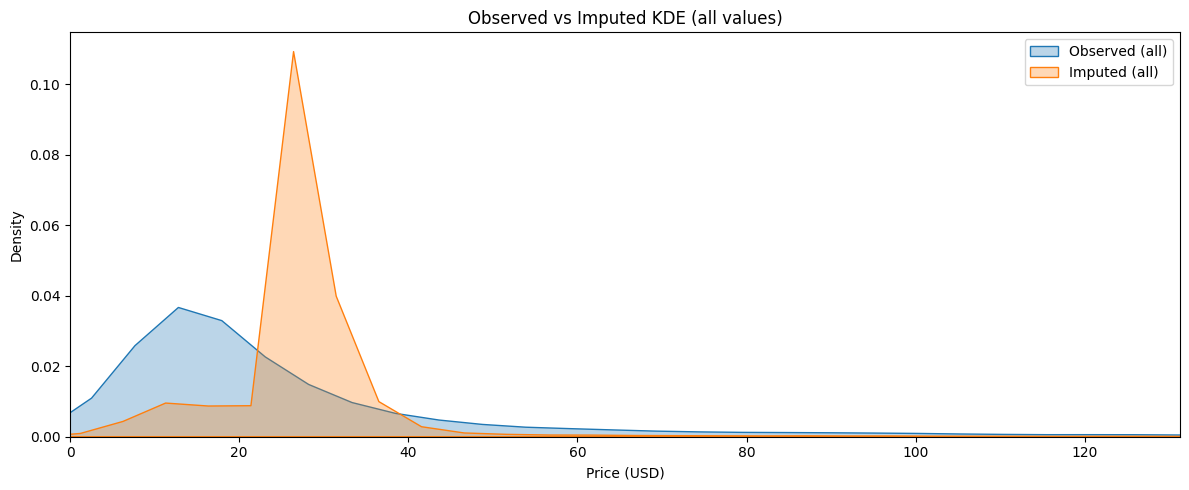


------------------------------------------------------------

Plotting filtered KDE comparisons (≤ 95th percentile of combined observed+imputed)
Overlayed KDE: Observed vs Imputed (filtered)


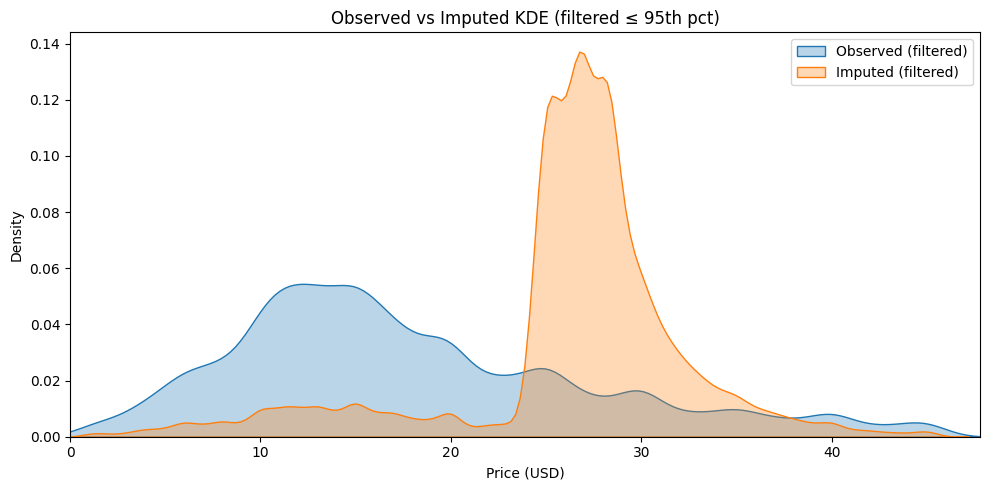


------------------------------------------------------------

Plotting synthetic-only histogram + KDE (filtered ≤ 95th pct of all)


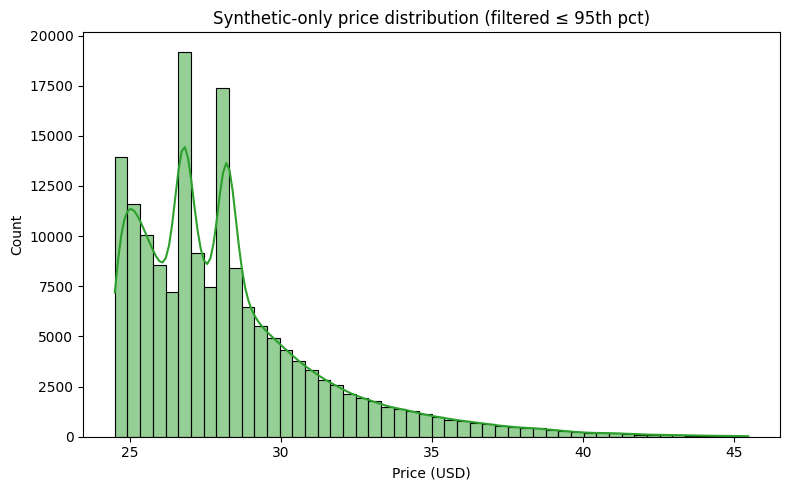

Synthetic-only filtered stats: {'n': 165913, 'mean': 28.27, 'median': 27.6, 'p05': 24.71, 'p95': 34.86}


In [24]:
sec_book_inpt_price = df_model.copy()
col_model_filter =['isbn','title','authors','publication_year','publisher','description','price_usd_final', 'price_is_synthetic','genre','image_alternative','previewlink','infolink']
sec_book_inpt_price = sec_book_inpt_price[col_model_filter]
sec_book_inpt_price = sec_book_inpt_price.rename(columns={'price_usd_final':'price_usd'})

print("\nPlotting price KDEs, comparing before and after price value imputation")

# Prepare numeric positive series (used for both unfiltered and filtered plots)
obs = pd.to_numeric(sec_cleaned['price_usd'], errors='coerce').dropna()
imp = pd.to_numeric(sec_book_inpt_price['price_usd'], errors='coerce').dropna()
syn = pd.to_numeric(sec_book_inpt_price.loc[sec_book_inpt_price['price_is_synthetic'] == True, 'price_usd'], errors='coerce').dropna()

obs = obs[obs > 0]
imp = imp[imp > 0]
syn = syn[syn > 0]

# 1) Unfiltered overlayed KDE (use a high percentile for x-lim so we don't truncate too aggressively)
if len(obs) > 0 or len(imp) > 0:
    print("Overlayed KDE: Observed vs Imputed (all values, unfiltered)")
    plt.figure(figsize=(12,5))
    if len(obs) > 0:
        sns.kdeplot(obs, label="Observed (all)", color="C0", fill=True, alpha=0.3)
    if len(imp) > 0:
        sns.kdeplot(imp, label="Imputed (all)", color="C1", fill=True, alpha=0.3)
    plt.title("Observed vs Imputed KDE (all values)")
    plt.xlabel("Price (USD)")
    plt.legend()
    # cap at a high percentile (99th) to avoid extreme outliers but keep broad range
    try:
        ub_unf = float(np.nanpercentile(pd.concat([obs, imp]), 99))
        if np.isfinite(ub_unf) and ub_unf > 0:
            plt.xlim(0, ub_unf * 1.05)
    except Exception:
        pass
    plt.tight_layout()
    plt.show()
else:
    print("No data for unfiltered overlay")

print("\n" + "-"*60 + "\n")
print("Plotting filtered KDE comparisons (≤ 95th percentile of combined observed+imputed)")

# Shared upper bound at 95th percentile over combined observed+imputed (filtered)
if len(pd.concat([obs, imp])) > 0:
    ub = float(np.nanpercentile(pd.concat([obs, imp]), 95))
else:
    ub = None

if ub is not None and np.isfinite(ub) and ub > 0:
    obs_f = obs[obs <= ub]
    imp_f = imp[imp <= ub]
    syn_f = syn[syn <= ub]
else:
    obs_f, imp_f, syn_f = obs, imp, syn

# 2) Filtered overlayed KDE comparison
if len(obs_f) > 0 or len(imp_f) > 0:
    print("Overlayed KDE: Observed vs Imputed (filtered)")
    plt.figure(figsize=(10,5))
    if len(obs_f) > 0:
        sns.kdeplot(obs_f, label="Observed (filtered)", color="C0", fill=True, alpha=0.3)
    if len(imp_f) > 0:
        sns.kdeplot(imp_f, label="Imputed (filtered)", color="C1", fill=True, alpha=0.3)
    plt.title("Observed vs Imputed KDE (filtered ≤ 95th pct)")
    plt.xlabel("Price (USD)")
    plt.legend()
    if ub is not None and np.isfinite(ub) and ub > 0:
        plt.xlim(0, ub * 1.05)
    plt.tight_layout()
    plt.show()
else:
    print("No data for filtered overlay")

print("\n" + "-"*60 + "\n")
# 3) Synthetic-only distribution (filtered)
if len(syn_f) > 0:
    print("Plotting synthetic-only histogram + KDE (filtered ≤ 95th pct of all)")
    plt.figure(figsize=(8,5))
    sns.histplot(syn_f, bins=50, kde=True, color="C2", stat="count")
    plt.title("Synthetic-only price distribution (filtered ≤ 95th pct)")
    plt.xlabel("Price (USD)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Quick stats
    def stats(s):
        return {
            "n": int(s.shape[0]),
            "mean": float(np.round(s.mean(), 2)),
            "median": float(np.round(s.median(), 2)),
            "p05": float(np.round(s.quantile(0.05), 2)),
            "p95": float(np.round(s.quantile(0.95), 2)),
        }
    print("Synthetic-only filtered stats:", stats(syn_f))
else:
    print("No synthetic rows available for plotting.")


**Notes:** 
- The overall distribution changed a bit but it's still better than before with books mostly having no price at all.
- Having synthetic data with a slightely different distribution of prices is not ideal, but for the puropose of our recommendation system, more information is a big benefit.

In [25]:
# save alternative secundary book data with imputed prices
sec_out_imputed = interim_dir / "sec_books_cleaned_imputed.csv"
sec_rel_imputed = _compute_relative_target_dir(sec_out_imputed)
sec_book_inpt_price.to_csv(sec_out_imputed, index=True, encoding="utf-8")
print(f"\nSaved: {sec_rel_imputed} ({len(sec_book_inpt_price):,} rows)")


Saved: /book_rec_project/data/interim/sec_books_cleaned_imputed.csv (212,404 rows)



---

## 3. Preprocessing Users Dataset (`users.csv`)


**Goals:** We also want to have the following information:
- `location` transforming into `city`, `region` , `country`
- Get `loc_latitude` , `loc_longitude`, derived from `location` using geocoding API (geopy or similar)
- Create `gender` variable with values {`male`, `female`, `non_binary`} assigned randomly with age-stratified distributions based on reading habit research showing:
    - Women read more than men overall (60.5% vs 44.5% in EU, 2022)
    - Gender gap is smallest among young adults (18-24 years)
    - Gender gap increases with age, most pronounced in seniors (60+)
    - Adjust non-binary probability to reflect global prevalance estimates (~0.1%–2%), with higher prevalence reported in younger individuals
    - **Note:** empirical research on reading habits for non-binary people is very scarce. Assignments including a `non_binary` category are therefore provisional and based on limited evidence — treat results as indicative and validate against any available ground truth where possible.
    - Sources: 
        - [The Men-Women Split in Reading is Real—and Persists Amid Historical Rate Declines](https://www.arts.gov/stories/blog/2025/men-women-split-reading-real-and-persists-amid-historical-rate-declines) (NEA, Jan 10, 2025)
        - Google Gemini AI analysis of reading demographics

- Create `age_group` variable with values {`child_ls_12`, `juvenile_12_17`, `young_adult_18_24`, `adult_25_34`, `adult_35_49`, `adult_50_60`, `senior_gt_60`} based on `age` variable


**FLAGS** boolean columns:
- `is_synthetic_age`: true for missing `age` values where we assign synthetic ages based on overall age distribution
- `is_synthetic_location`: true for missing or invalid `location` values where we assign synthetic locations based on overall location distribution or partial valid information

---

### Age and gender columns

In [26]:
# Clean and preprocess user data
print("Cleaning users.csv -> users_cleaned.csv\n")
users_path = Path("../data/raw/users.csv")
if not users_path.exists():
    raise FileNotFoundError(f"{users_path} not found")

df_users = pd.read_csv(users_path, sep=",", low_memory=False)
print(f"Current columns in users.csv: {df_users.columns.tolist()}")
df_users = apply_column_map(df_users)
print(f"Columns after normalizing column names: {df_users.columns.tolist()}")

Cleaning users.csv -> users_cleaned.csv

Current columns in users.csv: ['User-ID', 'Location', 'Age']
Columns after normalizing column names: ['user_id', 'location', 'age']


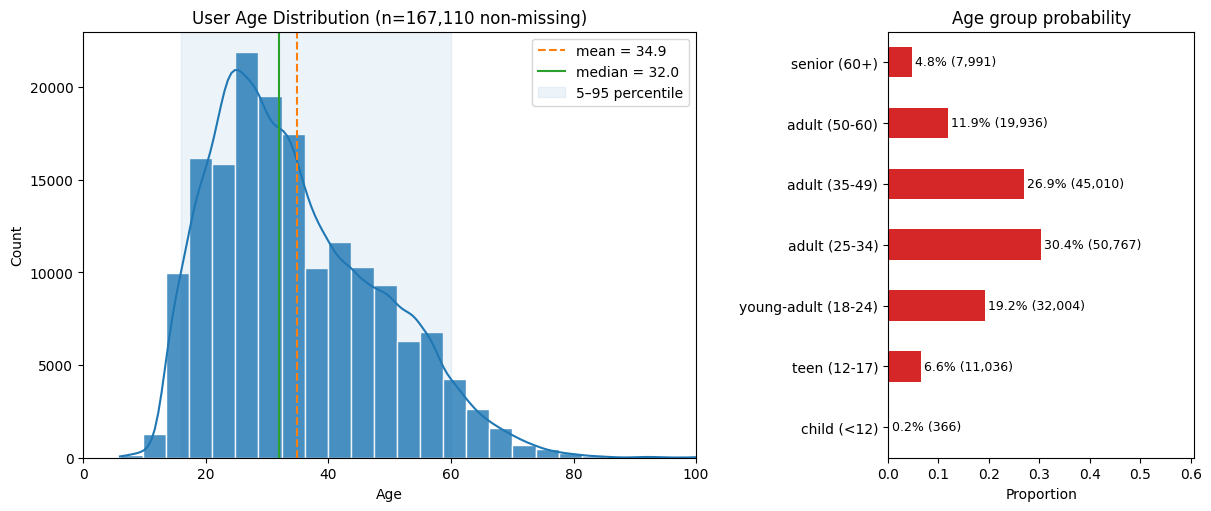

In [27]:
# Age distribution + age-group breakdown (proportions)
age = pd.to_numeric(df_users["age"], errors="coerce").dropna()
age_filtered = age[(age >= 6) & (age <= 120)]

if len(age_filtered) == 0:
    print("No valid ages to plot.")
else:
    # summary stats
    n = len(age_filtered)
    mean = age_filtered.mean()
    median = age_filtered.median()
    p05, p95 = age_filtered.quantile(0.05), age_filtered.quantile(0.95)

    # age groups (keep same bins/labels)
    bins = [0, 12, 18, 25, 35, 50, 61, 120]
    labels = [
        "child (<12)",
        "teen (12-17)",
        "young-adult (18-24)",
        "adult (25-34)",
        "adult (35-49)",
        "adult (50-60)",
        "senior (60+)"
    ]
    age_groups = pd.cut(age_filtered, bins=bins, labels=labels, right=False)

    # counts and proportions (probability distribution)
    group_counts = age_groups.value_counts().reindex(labels).fillna(0).astype(int)
    group_props = age_groups.value_counts(normalize=True).reindex(labels).fillna(0)

    # Figure + GridSpec: create GridSpec from the Figure to avoid the IPython/layoutgrids warning
    fig = plt.figure(figsize=(12, 5), constrained_layout=True)
    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.05)  # larger wspace to prevent overlap

    ax = fig.add_subplot(gs[0, 0])
    sns.histplot(age_filtered, bins=30, kde=True, color="C0", edgecolor="white", alpha=0.8, ax=ax)
    ax.axvline(mean, color="C1", linestyle="--", linewidth=1.5, label=f"mean = {mean:.1f}")
    ax.axvline(median, color="C2", linestyle="-", linewidth=1.5, label=f"median = {median:.1f}")
    ax.axvspan(p05, p95, color="C0", alpha=0.08, label="5–95 percentile")
    ax.set_title(f"User Age Distribution (n={n:,} non-missing)")
    ax.set_xlabel("Age")
    ax.set_ylabel("Count")
    ax.set_xlim(0, 100)
    ax.legend(frameon=True)

    ax2 = fig.add_subplot(gs[0, 1])
    # plot proportions as horizontal bar chart
    group_props.plot(kind="barh", color="C3", ax=ax2)

    # axis labels and title
    ax2.set_title("Age group probability")
    ax2.set_xlabel("Proportion")
    ax2.set_ylabel("")

    # annotate with percentage + raw count, avoid overlap by placing text just after bar end
    max_prop = group_props.max() if group_props.max() > 0 else 1.0
    for i, label in enumerate(labels):
        prop = group_props.loc[label]
        cnt = group_counts.loc[label]
        x = prop + max_prop * 0.02  # small offset
        ax2.text(x, i, f"{prop:.1%} ({int(cnt):,})", va="center", fontsize=9)

    # set x-axis limit a bit above the max proportion so annotations are visible
    ax2.set_xlim(0, min(1.0, max_prop * 2))

    plt.show()

Age imputation: 111,748 / 278,858 (40.1%) rows marked is_synthetic_age=True
Added columns: ['is_synthetic_age','age_imputed','age_group','gender']

Gender distribution by age group (counts):


gender,female,male,non-binary
age_group,,,
adult_25_34,46569,37244,821
adult_35_49,44223,30255,755
adult_50_60,19960,11325,143
child_ls_12,307,299,3
juvenile_12_17,9039,8845,547
senior_gt_60,9845,5191,12
young_adult_18_24,26987,23762,2726



Gender distribution by age group (proportions):


gender,female,male,non-binary
age_group,,,
adult_25_34,55.02,44.01,0.97
adult_35_49,58.78,40.22,1.00
adult_50_60,63.51,36.03,0.46
child_ls_12,50.41,49.10,0.49
juvenile_12_17,49.04,47.99,2.97
senior_gt_60,65.42,34.50,0.08
young_adult_18_24,50.47,44.44,5.10


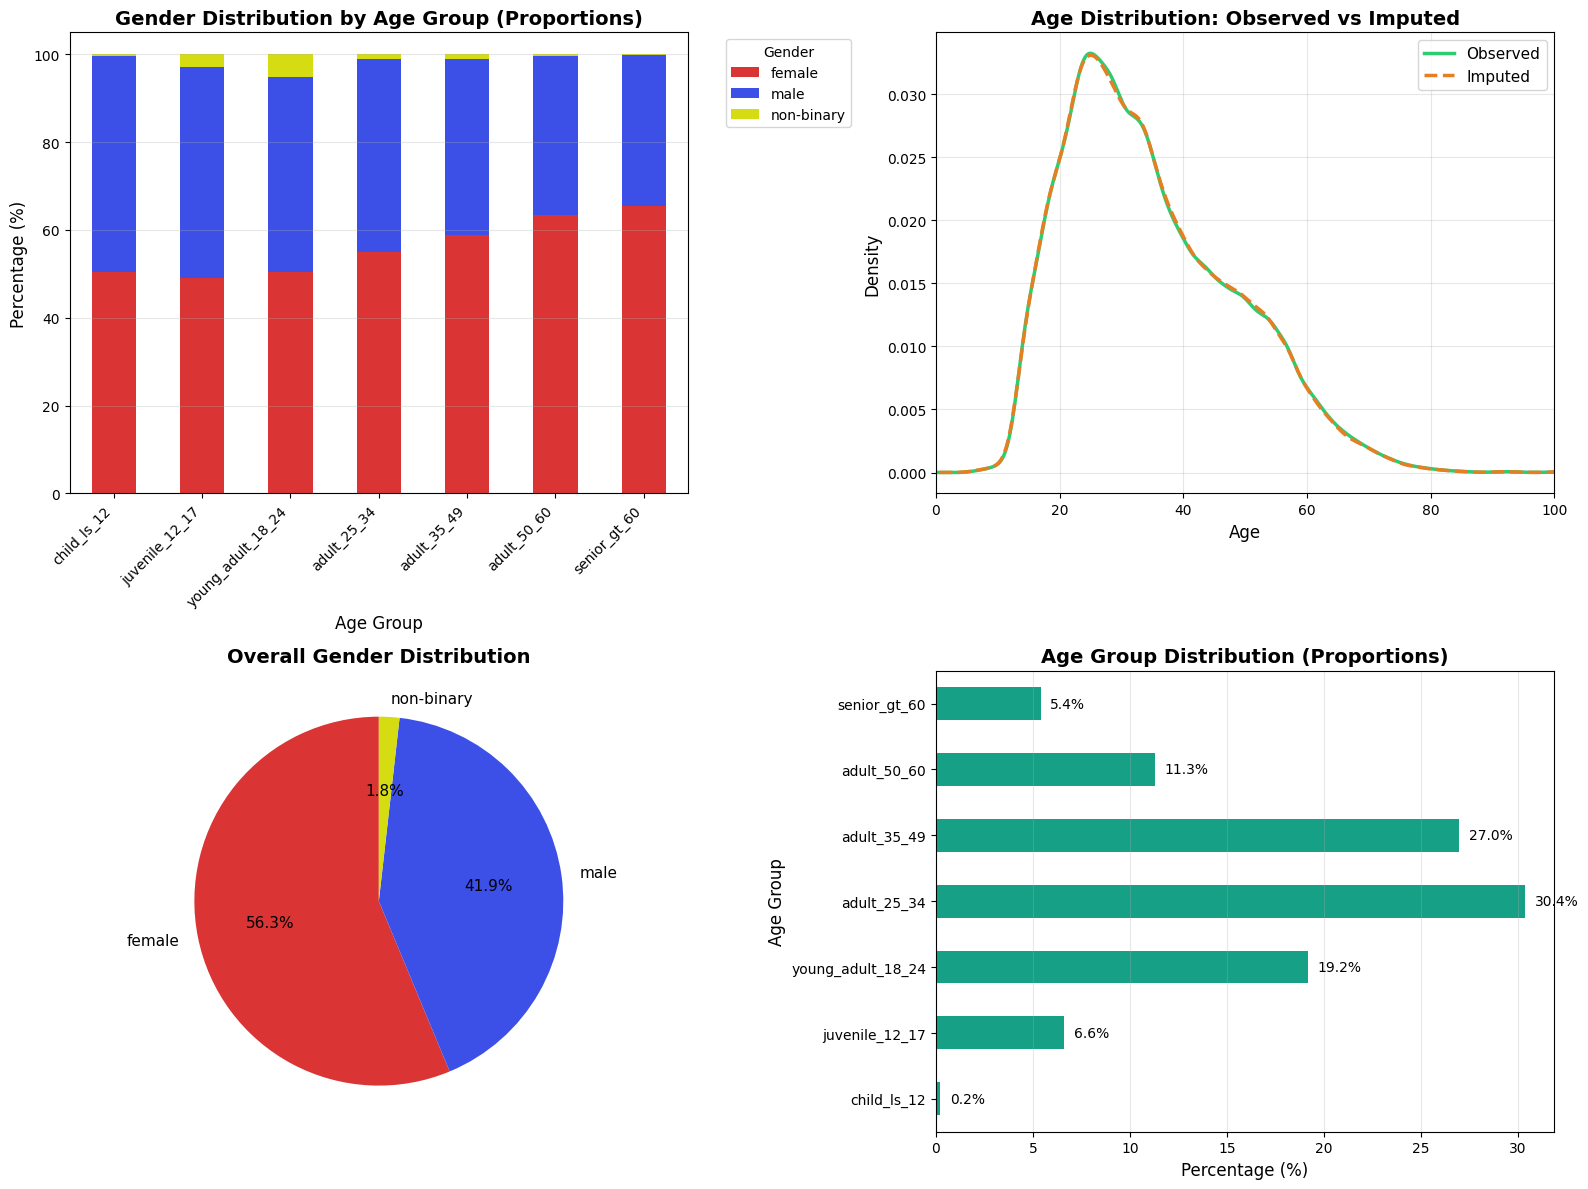


Preview of users_cleaned:


,user_id,location,age,is_synthetic_age,age_imputed,age_group,gender
0,1,"nyc, new york, usa",28,True,28,adult_25_34,male
1,2,"stockton, california, usa",18,False,18,young_adult_18_24,non-binary
2,3,"moscow, yukon territory, russia",60,True,60,senior_gt_60,male
3,4,"porto, v.n.gaia, portugal",17,False,17,juvenile_12_17,male
4,5,"farnborough, hants, united kingdom",43,True,43,adult_35_49,female
5,6,"santa monica, california, usa",61,False,61,senior_gt_60,female
6,7,"washington, dc, usa",36,True,36,adult_35_49,male
7,8,"timmins, ontario, canada",21,True,21,young_adult_18_24,male
8,9,"germantown, tennessee, usa",21,True,21,young_adult_18_24,female
9,10,"albacete, wisconsin, spain",26,False,26,adult_25_34,female


In [28]:
def age_to_category(age: Optional[Union[float, int]]) -> str:
    """Bucket an age into a coarse category.

    Categories:
    "child_ls_12" (<12),
    "juvenile_12_17" (12-17),
    "young_adult_18_24" (18-24),
    "adult_25_34" (25-34),
    "adult_35_49" (35-49),
    "adult_50_60" (50-60),
    "senior_gt_60" (60+)
    "unknown" (missing or invalid)
    """
    if age is None:
        return "unknown"
    try:
        a = float(age)
        if math.isnan(a):
            return "unknown"
    except Exception:
        print(f"Exception converting age to float: {age}")
        return "unknown"

    if a < 12:
        return "child_ls_12"
    if a < 18:
        return "juvenile_12_17"
    if a < 25:
        return "young_adult_18_24"
    if a < 35:
        return "adult_25_34"
    if a < 50:
        return "adult_35_49"
    if a < 60:
        return "adult_50_60"
    if a >= 60:
        return "senior_gt_60"
    return "unknown"


def assign_gender(user_id: int, age: Optional[Union[float, int]] = None, 
                  allow_nonbinary: bool = True) -> str:
    """
    Assign a gender ("male", "female", "non-binary") based on user_id and optional age.
    The assignment is probabilistic, with age-aware distributions.

    Parameters:
    - user_id: int or None, used as seed for reproducibility.
    - age: optional float or int, used to determine age category for distribution.
    - allow_nonbinary: bool, whether to include non-binary

    Returns:
    - str: "male", "female", or "non-binary"
    """
    rng = random.Random(int(user_id) if user_id is not None else 0)
    
    # Determine age category if age is provided
    age_group = age_to_category(age) if age is not None else "unknown"
    
    if allow_nonbinary:
        # Adjust non-binary probability to reflect global estimates (~0.1%–2%),
        # with higher prevalence in younger cohorts (evidence shows more youth reporting).
        # Probabilities sum to 1.0 per age group.
        if age_group == "child_ls_12":
            # Very low observed identification in very young children
            male_prob = 0.495
            female_prob = 0.500
            nonbinary_prob = 0.005

        elif age_group == "juvenile_12_17":
            # Teens: higher than children but still relatively low
            male_prob = 0.475
            female_prob = 0.495
            nonbinary_prob = 0.030

        elif age_group == "young_adult_18_24":
            # Young adults: substantially higher non-binary proportion reported in surveys
            male_prob = 0.450
            female_prob = 0.500
            nonbinary_prob = 0.050

        elif age_group == "adult_25_34":
            # Adults 25-34: moderate, closer to general adult estimates
            male_prob = 0.440
            female_prob = 0.550
            nonbinary_prob = 0.010

        elif age_group == "adult_35_49":
            male_prob = 0.400
            female_prob = 0.590
            nonbinary_prob = 0.010

        elif age_group == "adult_50_60":
            # Older adults: lower non-binary share
            male_prob = 0.365
            female_prob = 0.630
            nonbinary_prob = 0.005

        elif age_group == "senior_gt_60":
            # Seniors: very small non-binary proportion
            male_prob = 0.339
            female_prob = 0.660
            nonbinary_prob = 0.001

        else:  # "unknown"
            # Default conservative estimate near global averages
            male_prob = 0.440
            female_prob = 0.550
            nonbinary_prob = 0.010

        r = rng.random()
        if r < male_prob:
            return "male"
        if r < (male_prob + female_prob):
            return "female"
        return "non-binary"
        
    else:
        # Binary distribution (age-aware)
        if age_group == "child_ls_12":
            return rng.choices(["male", "female"], weights=[0.49, 0.51])[0]
        elif age_group == "juvenile_12_17":
            return rng.choices(["male", "female"], weights=[0.46, 0.54])[0]
        elif age_group == "young_adult_18_24":
            # Nearly balanced for young adults (18-24)
            return rng.choices(["male", "female"], weights=[0.48, 0.52])[0]
        elif age_group == "adult_25_34":
            return rng.choices(["male", "female"], weights=[0.45, 0.55])[0]
        elif age_group == "adult_35_49":
            return rng.choices(["male", "female"], weights=[0.41, 0.59])[0]
        elif age_group == "adult_50_60":
            # Strong female skew for older readers (50-60)
            return rng.choices(["male", "female"], weights=[0.37, 0.63])[0]
        elif age_group == "senior_gt_60":
            # Strongest female skew for seniors
            return rng.choices(["male", "female"], weights=[0.34, 0.66])[0]
        else:
            # Default moderate skew
            return rng.choices(["male", "female"], weights=[0.44, 0.56])[0]


def impute_ages_and_flags(df_users: pd.DataFrame, random_seed: int = 42) -> pd.DataFrame:
    """Impute missing/invalid ages, add is_synthetic_age, age_imputed and age_group.

    Rules:
    - Valid ages: 6..120
    - If some observed valid ages exist, sample missing ages from that empirical distribution.
      Otherwise use a small fallback distribution biased toward young adults/adults.
    - Mark is_synthetic_age=True only for rows that were missing or invalid originally.
    """
    df = df_users.copy()
    # preserve original numeric coercion
    # use bracket access to ensure a Series is passed to pd.to_numeric (avoids typing/language-server overload issues)
    age_raw = pd.to_numeric(df["age"], errors="coerce")

    valid_mask = age_raw.between(6, 120)
    observed = age_raw[valid_mask].dropna().astype(int)

    # positions to impute (missing or invalid)
    missing_or_invalid_mask = (~valid_mask) | age_raw.isna()
    n_missing = int(missing_or_invalid_mask.sum())

    rng = np.random.RandomState(random_seed)

    if n_missing > 0:
        if len(observed) == 0:
            # fallback distribution (deterministic given seed)
            fallback_choices = np.array([10, 15, 20, 25, 30, 35, 45, 55, 65, 75])
            fallback_probs = np.array([0.01, 0.02, 0.20, 0.25, 0.20, 0.12, 0.10, 0.06, 0.03, 0.01])
            fallback_probs = fallback_probs / fallback_probs.sum()
            sampled = rng.choice(fallback_choices, size=n_missing, p=fallback_probs)
        else:
            # use to_numpy() to produce a plain numpy array (satisfies type checkers)
            vals, counts = np.unique(observed.to_numpy(), return_counts=True)
            probs = counts / counts.sum()
            sampled = rng.choice(vals, size=n_missing, p=probs)
        # create age_imputed series starting from raw
        age_imputed = age_raw.copy()
        age_imputed.loc[missing_or_invalid_mask] = sampled
    else:
        age_imputed = age_raw.copy()

    # cast to pandas nullable Int64
    age_imputed = age_imputed.round().astype("Int64")

    # synthetic flag: True where we assigned a value because original was missing/invalid
    df["is_synthetic_age"] = missing_or_invalid_mask.astype(bool)

    # store imputed and final age
    df["age_imputed"] = age_imputed
    # overwrite working age with imputed values (consistent int dtype)
    df["age"] = df["age_imputed"]

    # add age_group using age_to_category
    df["age_group"] = df["age"].apply(lambda x: age_to_category(x) if pd.notna(x) else "unknown")

    return df


def assign_genders_to_users(df_users: pd.DataFrame, allow_nonbinary: bool = True) -> pd.DataFrame:
    """Assign gender to all users based on user_id and age (after age imputation).
    
    Args:
        df_users: DataFrame with 'user_id' and 'age' columns (age should already be imputed)
        allow_nonbinary: Whether to include non-binary gender option
    
    Returns:
        DataFrame with added 'gender' column
    """
    df = df_users.copy()
    
    # Ensure age column exists
    if "age" not in df.columns:
        raise ValueError("DataFrame must have 'age' column. Run impute_ages_and_flags first.")
    
    # Assign gender using both user_id and age
    df["gender"] = df.apply(
        lambda row: assign_gender(
            user_id=row.get("user_id"),
            age=row.get("age"),
            allow_nonbinary=allow_nonbinary
        ),
        axis=1
    )
    
    return df


# 1. Apply age imputation first
users_cleaned = df_users.copy()
users_cleaned = impute_ages_and_flags(users_cleaned, random_seed=42)

# 2. Then assign gender based on imputed ages
users_cleaned = assign_genders_to_users(users_cleaned, allow_nonbinary=True)

# Quick summary print
n_total = len(users_cleaned)
n_synth = int(users_cleaned["is_synthetic_age"].sum())
print(f"Age imputation: {n_synth:,} / {n_total:,} ({n_synth / n_total:.1%}) rows marked is_synthetic_age=True")
print("Added columns: ['is_synthetic_age','age_imputed','age_group','gender']")

print("\nGender distribution by age group (counts):")
display(users_cleaned.groupby(["age_group", "gender"]).size().unstack(fill_value=0))

print("\nGender distribution by age group (proportions):")
gender_props = users_cleaned.groupby(["age_group", "gender"]).size().unstack(fill_value=0)
gender_props_pct = gender_props.div(gender_props.sum(axis=1), axis=0) * 100
display(gender_props_pct.round(2))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gender distribution by age group (stacked bar - proportions)
ax1 = axes[0, 0]
# Define proper age group order from youngest to oldest
age_group_order = [
    "child_ls_12",
    "juvenile_12_17", 
    "young_adult_18_24",
    "adult_25_34",
    "adult_35_49",
    "adult_50_60",
    "senior_gt_60",
    "unknown"
]

colors = ["#db3434", "#3c50e7", "#d5dc12"]
# Reindex gender proportions to follow age group order
existing_order = [cat for cat in age_group_order if cat in gender_props_pct.index]
gender_props_pct_ordered = gender_props_pct.reindex(existing_order)

gender_props_pct_ordered.plot(kind='bar', stacked=True, ax=ax1, 
                              color=colors)
ax1.set_title('Gender Distribution by Age Group (Proportions)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Age Group', fontsize=12)
ax1.set_ylabel('Percentage (%)', fontsize=12)
ax1.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# 2. Age distribution: Observed vs Imputed (KDE plot)
ax2 = axes[0, 1]
observed_ages = users_cleaned[~users_cleaned["is_synthetic_age"]]["age"].dropna()
imputed_ages = users_cleaned[users_cleaned["is_synthetic_age"]]["age"].dropna()

if len(observed_ages) > 0:
    observed_ages.plot(kind='kde', ax=ax2, label='Observed', linewidth=2.5, color='#2ecc71')
if len(imputed_ages) > 0:
    imputed_ages.plot(kind='kde', ax=ax2, label='Imputed', linewidth=2.5, color='#e67e22', linestyle='--')

ax2.set_title('Age Distribution: Observed vs Imputed', fontsize=14, fontweight='bold')
ax2.set_xlabel('Age', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)
ax2.set_xlim(0, 100)

# 3. Gender distribution overall (pie chart with proportions)
ax3 = axes[1, 0]
gender_counts = users_cleaned['gender'].value_counts()
ax3.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 11})
ax3.set_title('Overall Gender Distribution', fontsize=14, fontweight='bold')

# 4. Age group distribution (horizontal bar with proportions)
ax4 = axes[1, 1]

# Get proportions and reindex according to order (only include categories that exist)
age_group_props = users_cleaned['age_group'].value_counts(normalize=True) * 100
# Filter order to only include categories present in data
existing_order = [cat for cat in age_group_order if cat in age_group_props.index]
age_group_props = age_group_props.reindex(existing_order)

age_group_props.plot(kind='barh', ax=ax4, color='#16a085')
ax4.set_title('Age Group Distribution (Proportions)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Percentage (%)', fontsize=12)
ax4.set_ylabel('Age Group', fontsize=12)
ax4.grid(axis='x', alpha=0.3)

# Add percentage labels on bars
for i, v in enumerate(age_group_props.values):
    ax4.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nPreview of users_cleaned:")
display(users_cleaned.head(10))

In [29]:
users_cleaned.drop(columns=['age'], inplace=True)
users_cleaned.rename(columns={'age_imputed':'age'}, inplace=True)
print(f"Curent users columns: {list(users_cleaned.columns)}")
users_out_path = interim_dir / "users_cleaned.csv"
users_rel_out = _compute_relative_target_dir(users_out_path)
users_cleaned.to_csv(users_out_path, index=True, encoding="utf-8")
print(f"\nSaved: {users_rel_out} ({len(users_cleaned):,} rows)")

Curent users columns: ['user_id', 'location', 'is_synthetic_age', 'age', 'age_group', 'gender']

Saved: /book_rec_project/data/interim/users_cleaned.csv (278,858 rows)


#### ⚠️ Note on Gender Assignment Methodology

**Approach Used:** Age-stratified random assignment based on reading demographics research.

**Limitations & Considerations:**
- **Simplified model**: Does not account for individual genre preferences (e.g., men preferring fantasy/sci-fi, women preferring romance/historical fiction)
- **Trade-off accepted**: Prioritizes simplicity, reproducibility, and universal coverage over maximum realism
- **Theoretical soundness**: Gender influences genre preference (not vice versa), so assigning gender based on rated genres would introduce circular logic
- **Coverage**: Works for ALL users, including those with no ratings or missing book genre data

**Why This Approach:**
1. **Causality**: Maintains proper causal direction (gender → reading behavior, not reading behavior → gender)
2. **Clean analysis**: Enables unbiased analysis of how gender affects reading patterns
3. **Sufficient signal**: Age-based distributions capture the primary demographic pattern (women read more, gap increases with age)

**Future Validation:** 
A follow-up analysis could validate these assignments by checking if users assigned 'male' show higher rates of fantasy/sci-fi ratings, and 'female' show higher romance/historical fiction rates. This would serve as a validation check rather than an assignment criterion.

---

### 3.2 Location Processing: Standardization, Imputation & Geocoding

**Objective:** Transform the raw `location` column into structured, standardized location data with geographic coordinates.

**Processing Pipeline:**

1. **Parse & Standardize** (`expand_and_standardize_locations`)
   - Split `location` string into `city`, `state/region`, `country` components
   - Normalize and match against authoritative sources:
     - **Countries**: Using `pycountry` with fuzzy matching (≥90% similarity)
     - **States/Regions**: Using `geonamescache` for US states and international admin1 codes
     - **Cities**: Validate uniqueness and apply title-case normalization
   - Output: `city_std`, `state_std`, `country_iso2`, `country_name`

2. **Probabilistic Imputation** (`probabilistic_location_imputation`)
   - **Strategy**: Sample from empirical distributions of observed valid locations
   - **Hierarchical imputation**:
     - If country missing → sample country from overall distribution
     - If state missing → sample state given country
     - If city missing → sample city given (country, state) or fallback to country-level
   - **Flag**: `is_synthetic_location = True` for users where country was completely missing
   - Uses seed-based reproducibility (user index + random_seed)

3. **Geocoding** (`add_coordinates`)
   - Convert standardized locations to geographic coordinates using **geopy (Nominatim)**
   - **Optimization**: Geocode unique locations only (reduces API calls)
   - **Rate limiting**: Configurable delay between requests (default: 1s)
   - **Retry logic**: Handles timeouts and service errors gracefully
   - Output: `latitude`, `longitude`

**Data Sources:**
- `pycountry`: ISO 3166 country codes and names
- `geonamescache`: Global cities, US states, and administrative divisions
- `geopy/Nominatim`: OpenStreetMap geocoding service

**Output Columns:**
- `city_std`, `state_std`, `country_iso2`, `country_name` (standardized)
- `city_std_imputed`, `state_std_imputed`, `country_iso2_imputed` (after imputation)
- `latitude`, `longitude` (geographic coordinates)
- `is_synthetic_location` (boolean flag)

In [30]:
# from typing import Optional, Dict, Tuple

# # Initialize geocoder
# geolocator = Nominatim(user_agent="book_recommendation_analysis")

# # Build lookup dictionaries ONCE at module level for performance
# gc = geonamescache.GeonamesCache()

# # --- 1. Normalization Function to Use ---
# def _normalize_token(token: str) -> str:
#     """Strict normalization for exact matching - removes all special chars."""
#     if not token or pd.isna(token):
#         return ""
#     token = unicodedata.normalize("NFKD", str(token))
#     token = token.encode("ascii", "ignore").decode("ascii")
#     # Remove all non-alphanumeric, non-space characters
#     token = re.sub(r"[^a-z0-9\s]", "", token.strip().lower())
#     token = re.sub(r"\s+", " ", token).strip() # Consolidate whitespace
#     return token

# # --- 2. Build ONE Country Map (using the strict normalizer) ---
# _country_map: Dict[str, Dict[str, str]] = {}
# for c in pycountry.countries:
#     names = {c.name}
#     if hasattr(c, "official_name"):
#         names.add(c.official_name)
#     if hasattr(c, "alpha_2"):
#         names.add(c.alpha_2)
#     if hasattr(c, "alpha_3"):
#         names.add(c.alpha_3)
    
#     countries_dict = gc.get_countries()
#     if c.alpha_2 in countries_dict:
#         data = countries_dict[c.alpha_2]
#         if data and isinstance(data, dict) and data.get("name"):
#             names.add(data.get("name"))
    
#     # Your excellent manual alias list
#     common_names = {
#         'US': ['usa', 'united states', 'united states of america', 'u.s.a', 'u.s.', 'us', 'united states'],
#         'GB': ['uk', 'united kingdom', 'great britain', 'u.k.', 'england', 'scotland', 'wales'],
#         'DE': ['germany', 'deutschland'],
#         'IT': ['italy', 'italia', "l'italia", "l`italia"],
#         'ES': ['spain', 'españa', 'espana'],
#         'FR': ['france', 'la france'],
#         'NL': ['netherlands', 'holland', 'nederland'],
#         'CN': ['china', 'p.r.c.', 'prc', "people's republic of china"],
#         'BR': ['brazil', 'brasil'],
#         'MX': ['mexico', 'méxico'],
#         'AU': ['australia'],
#         'CA': ['canada'],
#         'NZ': ['new zealand'],
#         'PT': ['portugal'],
#         'CH': ['switzerland', 'suisse', 'schweiz', 'la svizzera'],
#         'BE': ['belgium', 'belgique', 'belgië'],
#         'AT': ['austria', 'österreich'],
#         'SE': ['sweden', 'sverige'],
#         'NO': ['norway', 'norge'],
#         'DK': ['denmark', 'danmark'],
#         'FI': ['finland', 'suomi'],
#         'IE': ['ireland', 'éire'],
#         'GR': ['greece', 'hellas'],
#         'PL': ['poland', 'polska'],
#         'TR': ['turkey', 'türkiye'],
#         'IN': ['india', 'bharat'],
#         'JP': ['japan', 'nippon'],
#         'KR': ['south korea', 'korea', 'rok'],
#         'MY': ['malaysia'],
#         'SG': ['singapore'],
#         'TH': ['thailand'],
#         'PH': ['philippines'],
#         'ID': ['indonesia'],
#         'VN': ['vietnam'],
#         'AE': ['uae', 'u.a.e', 'united arab emirates'],
#         'IL': ['israel'],
#         'SA': ['saudi arabia'],
#         'EG': ['egypt'],
#         'ZA': ['south africa'],
#         'AR': ['argentina', 'la argentina'],
#         'CL': ['chile'],
#         'CO': ['colombia'],
#         'PE': ['peru'],
#         'VE': ['venezuela'],
#         'CR': ['costa rica'],
#         'PA': ['panama'],
#         'HK': ['hong kong'],
#         'TW': ['taiwan', 'r.o.c.'],
#         'RO': ['romania'],
#         'HR': ['croatia'],
#         'SK': ['slovakia'],
#         'SI': ['slovenia'],
#         'BG': ['bulgaria'],
#         'CZ': ['czech republic', 'czechia'],
#         'HU': ['hungary'],
#         'NG': ['nigeria'],
#         'RS': ['serbia'],
#         'RU': ['russia', 'russian federation'],
#         'UA': ['ukraine'],
#         'YU': ['yugoslavia'],
#     }
    
#     if c.alpha_2 in common_names:
#         names.update(common_names[c.alpha_2])
    
#     # Store with ONE normalization level
#     for n in names:
#         if n:
#             key_strict = _normalize_token(n) # Use the one, strict function
#             if key_strict:
#                 _country_map[key_strict] = {"iso2": c.alpha_2, "name": c.name}

# _country_keys = list(_country_map.keys()) # Only one list of keys needed

# # --- 3. Build ONE Admin1 Map (using the strict normalizer) ---
# _admin1_map: Dict[str, Dict[str, str]] = {}
# for s in pycountry.subdivisions:
#     country_iso2 = s.country_code
#     name = s.name
#     code = s.code.split('-')[-1]
    
#     aliases = {name, code}
    
#     for alias in aliases:
#         norm_alias = _normalize_token(alias) # Use the one, strict function
#         if norm_alias:
#             _admin1_map.setdefault(country_iso2, {})[norm_alias] = name

# # --- 4. Define the Matching Functions (These were missing) ---
# def match_country(raw: str, fuzzy: bool = True, min_score: int = 85) -> Optional[Dict[str, str]]:
#     """Match raw country string to standardized country."""
#     if not raw or pd.isna(raw):
#         return None
    
#     # Use the one, strict normalizer on the input
#     norm = _normalize_token(raw)
#     if not norm:
#         return None
    
#     # Exact match first
#     if norm in _country_map:
#         return _country_map[norm]
    
#     # Fuzzy match with lower threshold for speed
#     if fuzzy:
#         result = process.extractOne(norm, _country_keys, scorer=fuzz.WRatio, score_cutoff=min_score)
#         if result:
#             return _country_map[result[0]]
#     return None


# def match_admin1(raw: str, country_iso2: str, fuzzy: bool = True, min_score: int = 85) -> Optional[str]:
#     """Match raw state/region string to standardized admin1."""
#     if not raw or pd.isna(raw) or not country_iso2 or country_iso2 not in _admin1_map:
#         return None
    
#     # Use the one, strict normalizer on the input
#     norm = _normalize_token(raw)
#     if not norm:
#         return None
    
#     m = _admin1_map[country_iso2]
    
#     # Exact match first
#     if norm in m:
#         return m[norm]
    
#     # Fuzzy match with lower threshold
#     if fuzzy:
#         result = process.extractOne(norm, list(m.keys()), scorer=fuzz.WRatio, score_cutoff=min_score)
#         if result:
#             return m[result[0]]
#     return None

# # --- 5. Update clean_location_row to use the strict normalizer ---
# def clean_location_row(city: str, state: str, country: str) -> Dict[str, Optional[str]]:
#     """Clean and standardize a single location row.
#     - keep raw_country for geocoding when iso2 is missing
#     - try to match iso2/name but do not discard raw tokens
#     """
#     city_n = _normalize_token(city) if pd.notna(city) else None
#     state_n = _normalize_token(state) if pd.notna(state) else None
#     country_raw = str(country).strip() if pd.notna(country) else None
#     country_n = _normalize_token(country_raw) if country_raw else None

#     # Try to match country (may be None)
#     country_match = match_country(country_n) if country_n else None
#     country_iso2 = country_match["iso2"] if country_match else None
#     country_name = country_match["name"] if country_match else None

#     # State match only if we have country iso2 (but it's optional)
#     state_match = match_admin1(state_n, country_iso2) if state_n and country_iso2 else None

#     # City: simple validation
#     city_std = city_n.title() if city_n and re.search(r"[a-z]", city_n) and len(city_n) > 1 else None

#     # Determine best freeform country string to use for geocoding:
#     # prefer official matched country_name, else raw token (unchanged), else None
#     country_for_geocode = country_name or country_raw

#     return {
#         "city_std": city_std,
#         "state_std": state_match,
#         "country_iso2": country_iso2,
#         "country_name": country_name,
#         "country_raw": country_raw,
#         "country_for_geocode": country_for_geocode
#     }

# def expand_and_standardize_locations(df: pd.DataFrame, location_col: str = "location") -> Tuple[pd.DataFrame, Dict]:
#     """Split Location into city/state/country, then standardize. Optimized for speed."""
#     print(f"Processing {len(df):,} location records...")
    
#     # Split locations efficiently
#     s = df[location_col].astype(str)
#     parts = s.str.split(",", n=2, expand=True)
#     while parts.shape[1] < 3:
#         parts[parts.shape[1]] = None
    
#     # Clean up parts
#     for i in range(3):
#         parts[i] = parts[i].astype(str).str.strip().replace({"": pd.NA, "nan": pd.NA})

#     out = df.copy()
#     out["raw_city"], out["raw_state"], out["raw_country"] = parts[0], parts[1], parts[2]

#     # Vectorized approach: process unique combinations only
#     unique_locs = out[["raw_city", "raw_state", "raw_country"]].drop_duplicates()
#     print(f"  Processing {len(unique_locs):,} unique location combinations...")
    
#     # Apply cleaning to unique locations only
#     enriched_unique = unique_locs.apply(
#         lambda r: clean_location_row(r["raw_city"], r["raw_state"], r["raw_country"]),
#         axis=1, result_type="expand"
#     )
    
#     # Merge back to original dataframe
#     unique_locs_enriched = pd.concat([unique_locs.reset_index(drop=True), enriched_unique], axis=1)
    
#     out = out.merge(
#         unique_locs_enriched,
#         on=["raw_city", "raw_state", "raw_country"],
#         how="left"
#     )

#     # Calculate unresolved
#     unresolved_country = out[out["country_iso2"].isna() & out["raw_country"].notna()]["raw_country"].value_counts().to_dict()
#     unresolved_state = out[out["state_std"].isna() & out["raw_state"].notna() & out["country_iso2"].notna()]["raw_state"].value_counts().to_dict()

#     return out, {
#         "unresolved_country_values": unresolved_country,
#         "unresolved_state_values": unresolved_state
#     }

# print("✓ Location standardization functions updated")

# def build_location_distributions(df: pd.DataFrame) -> Dict:
#     """Build probability distributions from observed valid locations."""
#     valid = df[df['country_iso2'].notna()].copy()
    
#     country_dist = Counter(valid['country_iso2'])
    
#     state_given_country = {}
#     for country in valid['country_iso2'].unique():
#         if pd.isna(country):
#             continue
#         country_states = valid[valid['country_iso2'] == country]['state_std'].dropna()
#         if len(country_states) > 0:
#             state_given_country[country] = Counter(country_states)
    
#     city_given_country_state = {}
#     for _, row in valid[valid['city_std'].notna()].iterrows():
#         country = row['country_iso2']
#         state = row['state_std'] if pd.notna(row['state_std']) else None
#         city = row['city_std']
        
#         key = (country, state)
#         if key not in city_given_country_state:
#             city_given_country_state[key] = Counter()
#         city_given_country_state[key][city] += 1
    
#     city_given_country = {}
#     for country in valid['country_iso2'].unique():
#         if pd.isna(country):
#             continue
#         country_cities = valid[valid['country_iso2'] == country]['city_std'].dropna()
#         if len(country_cities) > 0:
#             city_given_country[country] = Counter(country_cities)
    
#     return {
#         'country': country_dist,
#         'state_given_country': state_given_country,
#         'city_given_country_state': city_given_country_state,
#         'city_given_country': city_given_country
#     }


# def sample_from_distribution(dist_counter: Counter, random_state: Optional[int] = None) -> Optional[str]:
#     """Sample one item from a Counter distribution."""
#     if not dist_counter or len(dist_counter) == 0:
#         return None
    
#     items = list(dist_counter.keys())
#     weights = list(dist_counter.values())
    
#     rng = np.random.RandomState(random_state)
#     return rng.choice(items, p=np.array(weights)/sum(weights))


# def impute_location(row: pd.Series, distributions: Dict, random_state: Optional[int] = None) -> Tuple[Optional[str], Optional[str], Optional[str]]:
#     """Impute missing location data based on what's available."""
#     country = row['country_iso2']
#     state = row['state_std']
#     city = row['city_std']
    
#     # Case 1: No valid country -> impute everything
#     if pd.isna(country):
#         country = sample_from_distribution(distributions['country'], random_state)
#         if country:
#             state = sample_from_distribution(
#                 distributions['state_given_country'].get(country, Counter()), 
#                 random_state
#             )
#             if state:
#                 city = sample_from_distribution(
#                     distributions['city_given_country_state'].get((country, state), Counter()),
#                     random_state
#                 )
#             else:
#                 city = sample_from_distribution(
#                     distributions['city_given_country'].get(country, Counter()),
#                     random_state
#                 )
#         return country, state, city
    
#     # Case 2: Have country, missing state
#     if pd.isna(state):
#         state = sample_from_distribution(
#             distributions['state_given_country'].get(country, Counter()),
#             random_state
#         )
#         if state:
#             city = sample_from_distribution(
#                 distributions['city_given_country_state'].get((country, state), Counter()),
#                 random_state
#             )
#         else:
#             if pd.isna(city):
#                 city = sample_from_distribution(
#                     distributions['city_given_country'].get(country, Counter()),
#                     random_state
#                 )
#         return country, state, city
    
#     # Case 3: Have country and state, missing city
#     if pd.isna(city):
#         city = sample_from_distribution(
#             distributions['city_given_country_state'].get((country, state), Counter()),
#             random_state
#         )
#         if city is None:
#             city = sample_from_distribution(
#                 distributions['city_given_country'].get(country, Counter()),
#                 random_state
#             )
#         return country, state, city
    
#     # Case 4: Everything valid
#     return country, state, city


# def probabilistic_location_imputation(df: pd.DataFrame, random_seed: int = 42) -> pd.DataFrame:
#     """Apply probabilistic imputation to complete missing location data."""
#     df_imputed = df.copy()
    
#     print("Building location distributions from observed data...")
#     distributions = build_location_distributions(df_imputed)
    
#     print(f"  - {len(distributions['country'])} countries in distribution")
#     print(f"  - {len(distributions['state_given_country'])} countries with state data")
#     print(f"  - {len(distributions['city_given_country'])} countries with city data")
    
#     print("\nApplying probabilistic imputation...")
#     np.random.seed(random_seed)
    
#     imputed_locs = df_imputed.apply(
#         lambda row: impute_location(row, distributions, random_seed + row.name),
#         axis=1,
#         result_type='expand'
#     )
    
#     df_imputed['country_iso2_imputed'] = imputed_locs[0]
#     df_imputed['state_std_imputed'] = imputed_locs[1]
#     df_imputed['city_std_imputed'] = imputed_locs[2]
    
#     # Mark synthetic locations
#     df_imputed['is_synthetic_location'] = (
#         df_imputed['country_iso2'].isna() & 
#         df_imputed['country_iso2_imputed'].notna()
#     )
    
#     country_imputed = df_imputed['is_synthetic_location'].sum()
#     state_imputed = (df_imputed['state_std'].isna() & df_imputed['state_std_imputed'].notna()).sum()
#     city_imputed = (df_imputed['city_std'].isna() & df_imputed['city_std_imputed'].notna()).sum()
    
#     print("\nImputation results:")
#     print(f"  - Countries imputed: {country_imputed:,}")
#     print(f"  - States imputed: {state_imputed:,}")
#     print(f"  - Cities imputed: {city_imputed:,}")
    
#     return df_imputed


# def geocode_location(city: Optional[str], state: Optional[str], country_freeform: Optional[str],
#                      delay: float = 1.0) -> Tuple[Optional[float], Optional[float]]:
#     """
#     Build a freeform query using any available country text (not restricted to ISO2).
#     Returns (lat, lon) or (None, None). Includes basic retry/timeouts.
#     """
#     query_parts = []
#     if pd.notna(city) and city:
#         query_parts.append(str(city))
#     if pd.notna(state) and state:
#         query_parts.append(str(state))
#     if pd.notna(country_freeform) and country_freeform:
#         query_parts.append(str(country_freeform))

#     if not query_parts:
#         return None, None

#     query = ", ".join(query_parts)
#     try:
#         time.sleep(delay)
#         location = geolocator.geocode(query, timeout=10)
#         if location:
#             return location.latitude, location.longitude
#     except (GeocoderTimedOut, GeocoderServiceError) as e:
#         print(f"Geocoding error for '{query}': {e}")
#     except Exception as e:
#         print(f"Unexpected error for '{query}': {e}")
#     return None, None

# def add_coordinates(df: pd.DataFrame, batch_size: int = 100, delay: float = 1.0,
#                     max_requests: Optional[int] = None) -> pd.DataFrame:
#     """
#     Add latitude/longitude using geopy. Uses imputed or standardized columns when available,
#     but will fall back to original raw country tokens (country_for_geocode) so we DO NOT discard
#     unresolved country text.

#     Parameters:
#       - batch_size: progress print interval
#       - delay: seconds between requests
#       - max_requests: optional int to limit number of unique queries (useful for fast testing)
#     """
#     df_coords = df.copy()

#     # Final location tokens used for geocoding: prefer imputed -> standardized -> raw
#     df_coords['city_final'] = df_coords['city_std_imputed'].fillna(df_coords.get('city_std'))
#     df_coords['state_final'] = df_coords['state_std_imputed'].fillna(df_coords.get('state_std'))
#     # country_for_geocode should have been created by clean_location_row (country_name or raw)
#     df_coords['country_final_text'] = (
#         df_coords.get('country_for_geocode')
#         .fillna(df_coords.get('country_name'))
#         .fillna(df_coords.get('raw_country'))
#     )

#     df_coords['latitude'] = None
#     df_coords['longitude'] = None

#     unique_locs = df_coords[['city_final', 'state_final', 'country_final_text']].drop_duplicates().reset_index(drop=True)
#     total_unique = len(unique_locs)
#     if max_requests is not None and max_requests > 0:
#         unique_locs = unique_locs.head(max_requests)
#     print(f"\nGeocoding {len(unique_locs):,} unique locations (of {total_unique:,} total unique). "
#           f"Delay={delay}s, max_requests={max_requests}")

#     location_cache: Dict[Tuple, Tuple[Optional[float], Optional[float]]] = {}

#     for idx, row in unique_locs.iterrows():
#         if idx % batch_size == 0 and idx > 0:
#             print(f"  Processed {idx:,} / {len(unique_locs):,} locations...")
#         key = (row['city_final'], row['state_final'], row['country_final_text'])
#         if key in location_cache:
#             continue
#         lat, lon = geocode_location(row['city_final'], row['state_final'], row['country_final_text'], delay)
#         location_cache[key] = (lat, lon)

#     # Map coordinates back to dataframe using the same key construction
#     print("\nMapping coordinates to users...")
#     for idx, row in df_coords.iterrows():
#         key = (row['city_final'], row['state_final'], row['country_final_text'])
#         if key in location_cache:
#             df_coords.at[idx, 'latitude'] = location_cache[key][0]
#             df_coords.at[idx, 'longitude'] = location_cache[key][1]

#     success_rate = df_coords['latitude'].notna().sum() / len(df_coords) if len(df_coords) > 0 else 0
#     print(f"\nGeocoding complete: {df_coords['latitude'].notna().sum():,} / {len(df_coords):,} ({success_rate:.1%}) successfully geocoded")

#     return df_coords

In [31]:
# users_cleaned = pd.read_csv("../data/interim/users_cleaned.csv", index_col=0, encoding="utf-8")

# # Step 1: Parse and standardize locations
# print("="*60)
# print("STEP 1: Location Standardization")
# print("="*60)
# df_users_std, unresolved_summary = expand_and_standardize_locations(users_cleaned, "location")

# print("\nStandardization complete:")
# print(f"Resolved countries: {df_users_std['country_iso2'].notna().sum():,} / {len(df_users_std):,}")
# print(f"Resolved states: {df_users_std['state_std'].notna().sum():,} / {len(df_users_std):,}")
# print(f"Resolved cities: {df_users_std['city_std'].notna().sum():,} / {len(df_users_std):,}")

# print("\nUnresolved country tokens:")
# for token, count in pd.Series(unresolved_summary["unresolved_country_values"]).sort_values(ascending=False).head(500).items():
#     print(f"  {token}: {count:,}")

# print("\nUnresolved state tokens:")
# display(pd.Series(unresolved_summary["unresolved_state_values"]).sort_values(ascending=False).head(10))
# # Step 2: Probabilistic imputation
# print("\n" + "="*60)
# print("STEP 2: Probabilistic Location Imputation")
# print("="*60)
# df_users_imputed = probabilistic_location_imputation(df_users_std, random_seed=42)

# print("\nBEFORE vs AFTER Imputation:")
# print(f"Country - Before: {df_users_std['country_iso2'].notna().sum():,} | After: {df_users_imputed['country_iso2_imputed'].notna().sum():,}")
# print(f"State   - Before: {df_users_std['state_std'].notna().sum():,} | After: {df_users_imputed['state_std_imputed'].notna().sum():,}")
# print(f"City    - Before: {df_users_std['city_std'].notna().sum():,} | After: {df_users_imputed['city_std_imputed'].notna().sum():,}")

# # Sample of imputed records
# print("\nSample of synthetic locations (is_synthetic_location=True):")
# display(df_users_imputed[df_users_imputed['is_synthetic_location']][
#     ['location', 'country_iso2', 'country_iso2_imputed', 'state_std_imputed', 'city_std_imputed']
# ].head(10))

# # Step 3: Geocoding (WARNING: This will take time due to API rate limits!)
# print("\n" + "="*60)
# print("STEP 3: Geocoding (Adding Coordinates)")
# print("="*60)
# print("⚠️  This may take several minutes due to API rate limiting...")

# # For testing, you might want to run on a subset first:
# # df_sample = df_users_imputed.head(100)
# # df_with_coords = add_coordinates(df_sample, batch_size=50, delay=1.0)

# # Full dataset:
# df_with_coords = add_coordinates(df_users_imputed, batch_size=100, delay=1.0) # next time try smaller delay

# print("\nFinal location processing summary:")
# print(f"Total users: {len(df_with_coords):,}")
# print(f"Synthetic locations: {df_with_coords['is_synthetic_location'].sum():,} ({df_with_coords['is_synthetic_location'].sum()/len(df_with_coords):.1%})")
# print(f"Successfully geocoded: {df_with_coords['latitude'].notna().sum():,} ({df_with_coords['latitude'].notna().sum()/len(df_with_coords):.1%})")

# display(df_with_coords[['location', 'city_std_imputed', 'state_std_imputed', 'country_iso2_imputed', 
#                          'latitude', 'longitude', 'is_synthetic_location']].head(15))

**Note:** Took too long, pivoting to country only

In [32]:
from typing import Optional, Dict, Tuple

# Initialize geocoder
geolocator = Nominatim(user_agent="book_recommendation_analysis")

# Strict normalization for matching
def _normalize_token(token: str) -> str:
    """Strict normalization for exact matching - removes all special chars."""
    if not token or pd.isna(token):
        return ""
    token = unicodedata.normalize("NFKD", str(token))
    token = token.encode("ascii", "ignore").decode("ascii")
    # Remove all non-alphanumeric, non-space characters
    token = re.sub(r"[^a-z0-9\s]", "", token.strip().lower())
    token = re.sub(r"\s+", " ", token).strip()
    return token


# Build comprehensive country map with common aliases
_country_map: Dict[str, Dict[str, str]] = {}

# Common aliases for countries
common_names = {
    'US': ['usa', 'united states', 'united states of america', 'usa', 'us', 'u s a', 'u s'],
    'GB': ['uk', 'united kingdom', 'great britain', 'u k', 'england', 'scotland', 'wales', 'britain'],
    'DE': ['germany', 'deutschland'],
    'IT': ['italy', 'italia', 'litalia', 'l italia'],
    'ES': ['spain', 'espana', 'españa'],
    'FR': ['france', 'la france'],
    'NL': ['netherlands', 'holland', 'nederland'],
    'CN': ['china', 'prc', 'p r c', 'peoples republic of china'],
    'BR': ['brazil', 'brasil'],
    'MX': ['mexico', 'méxico'],
    'AU': ['australia'],
    'CA': ['canada'],
    'NZ': ['new zealand'],
    'PT': ['portugal'],
    'CH': ['switzerland', 'suisse', 'schweiz', 'svizzera'],
    'BE': ['belgium', 'belgique', 'belgie', 'belgië'],
    'AT': ['austria', 'osterreich', 'österreich'],
    'SE': ['sweden', 'sverige'],
    'NO': ['norway', 'norge'],
    'DK': ['denmark', 'danmark'],
    'FI': ['finland', 'suomi'],
    'IE': ['ireland', 'eire', 'éire'],
    'GR': ['greece', 'hellas'],
    'PL': ['poland', 'polska'],
    'TR': ['turkey', 'turkiye', 'türkiye'],
    'IN': ['india', 'bharat'],
    'JP': ['japan', 'nippon'],
    'KR': ['south korea', 'korea', 'rok', 's korea'],
    'MY': ['malaysia'],
    'SG': ['singapore'],
    'TH': ['thailand'],
    'PH': ['philippines'],
    'ID': ['indonesia'],
    'VN': ['vietnam', 'viet nam'],
    'AE': ['uae', 'u a e', 'united arab emirates', 'emirates'],
    'IL': ['israel'],
    'SA': ['saudi arabia'],
    'EG': ['egypt'],
    'ZA': ['south africa'],
    'AR': ['argentina'],
    'CL': ['chile'],
    'CO': ['colombia'],
    'PE': ['peru'],
    'VE': ['venezuela'],
    'CR': ['costa rica'],
    'PA': ['panama'],
    'HK': ['hong kong'],
    'TW': ['taiwan', 'r o c'],
    'RO': ['romania'],
    'HR': ['croatia'],
    'SK': ['slovakia'],
    'SI': ['slovenia'],
    'BG': ['bulgaria'],
    'CZ': ['czech republic', 'czechia'],
    'HU': ['hungary'],
    'NG': ['nigeria'],
    'RS': ['serbia'],
    'RU': ['russia', 'russian federation'],
    'UA': ['ukraine'],
    'YU': ['yugoslavia'],
}

# Build country map
for c in pycountry.countries:
    names = {c.name}
    if hasattr(c, "official_name"):
        names.add(c.official_name)
    if hasattr(c, "alpha_2"):
        names.add(c.alpha_2)
    if hasattr(c, "alpha_3"):
        names.add(c.alpha_3)
    
    # Add common aliases
    if c.alpha_2 in common_names:
        names.update(common_names[c.alpha_2])
    
    # Store with normalization
    for n in names:
        if n:
            key_strict = _normalize_token(n)
            if key_strict:
                _country_map[key_strict] = {"iso2": c.alpha_2, "name": c.name}

_country_keys = list(_country_map.keys())


def match_country(raw: str, fuzzy: bool = True, min_score: int = 80) -> Optional[Dict[str, str]]:
    """Match raw country string to standardized country. Fast version."""
    if not raw or pd.isna(raw):
        return None
    
    norm = _normalize_token(raw)
    if not norm:
        return None
    
    # Exact match first (fastest)
    if norm in _country_map:
        return _country_map[norm]
    
    # Fuzzy match with relaxed threshold
    if fuzzy:
        result = process.extractOne(norm, _country_keys, scorer=fuzz.WRatio, score_cutoff=min_score)
        if result:
            return _country_map[result[0]]
    return None


def extract_country_only(df: pd.DataFrame, location_col: str = "location") -> pd.DataFrame:
    """
    Fast country-only extraction from location string.
    Handles multiple formats: "city, state, country" OR "city, country" OR "country"
    Country is ALWAYS the last comma-separated part.
    """
    print(f"Processing {len(df):,} location records (country-only mode)...")
    
    out = df.copy()
    
    # Function to extract last part (country) from location string
    def extract_last_part(location_str):
        if pd.isna(location_str) or location_str == '' or str(location_str).lower() == 'nan':
            return None
        parts = [p.strip() for p in str(location_str).split(",")]
        # Filter out empty parts
        parts = [p for p in parts if p]
        if parts:
            return parts[-1]  # Last part is country
        return None
    
    out["raw_country"] = out[location_col].apply(extract_last_part)
    
    # Get unique countries for faster processing
    unique_countries = out[["raw_country"]].dropna().drop_duplicates()
    print(f"  Found {len(unique_countries):,} unique country values...")
    print(f"  Sample values: {list(unique_countries['raw_country'].head(10))}")
    
    # Match countries
    unique_countries["country_match"] = unique_countries["raw_country"].apply(match_country)
    unique_countries["country_iso2"] = unique_countries["country_match"].apply(
        lambda x: x["iso2"] if x else None
    )
    unique_countries["country_name"] = unique_countries["country_match"].apply(
        lambda x: x["name"] if x else None
    )
    unique_countries.drop(columns=["country_match"], inplace=True)
    
    # Merge back
    out = out.merge(unique_countries, on="raw_country", how="left")
    
    resolved = out["country_iso2"].notna().sum()
    unresolved = out["country_iso2"].isna().sum()
    total_valid = out["raw_country"].notna().sum()
    
    print(f"\nResults:")
    print(f"  Valid country strings: {total_valid:,}")
    print(f"  Resolved: {resolved:,} ({resolved/len(out)*100:.1f}% of total, {resolved/total_valid*100 if total_valid > 0 else 0:.1f}% of valid)")
    print(f"  Unresolved: {unresolved:,} ({unresolved/len(out)*100:.1f}%)")
    
    return out


def impute_missing_countries(df: pd.DataFrame, random_seed: int = 42) -> pd.DataFrame:
    """
    Impute missing countries based on distribution of observed countries.
    """
    df_imputed = df.copy()
    
    # Get valid country distribution
    valid_countries = df_imputed[df_imputed["country_iso2"].notna()]["country_iso2"]
    country_dist = Counter(valid_countries)
    
    if len(country_dist) == 0:
        print("Warning: No valid countries to impute from!")
        df_imputed["country_iso2_imputed"] = df_imputed["country_iso2"]
        df_imputed["country_name_imputed"] = df_imputed["country_name"]
        df_imputed["is_synthetic_location"] = False
        return df_imputed
    
    print(f"\nImputing from {len(country_dist)} observed countries...")
    print(f"Top 5 countries: {country_dist.most_common(5)}")
    
    # Sample missing countries
    missing_mask = df_imputed["country_iso2"].isna()
    n_missing = missing_mask.sum()
    
    if n_missing > 0:
        items = list(country_dist.keys())
        weights = np.array(list(country_dist.values()))
        weights = weights / weights.sum()
        
        rng = np.random.RandomState(random_seed)
        sampled_countries = rng.choice(items, size=n_missing, p=weights)
        
        df_imputed.loc[missing_mask, "country_iso2_imputed"] = sampled_countries
        
        # Map to country names
        iso2_to_name = dict(zip(df_imputed["country_iso2"], df_imputed["country_name"]))
        df_imputed.loc[missing_mask, "country_name_imputed"] = df_imputed.loc[missing_mask, "country_iso2_imputed"].map(iso2_to_name)
    else:
        df_imputed["country_iso2_imputed"] = df_imputed["country_iso2"]
        df_imputed["country_name_imputed"] = df_imputed["country_name"]
    
    # Fill non-missing with original values (avoid FutureWarning)
    df_imputed["country_iso2_imputed"] = df_imputed["country_iso2_imputed"].fillna(df_imputed["country_iso2"])
    df_imputed["country_name_imputed"] = df_imputed["country_name_imputed"].fillna(df_imputed["country_name"])
    
    # Mark synthetic locations
    df_imputed["is_synthetic_location"] = missing_mask
    
    print(f"\nImputed {n_missing:,} countries ({n_missing/len(df_imputed)*100:.1f}%)")
    
    return df_imputed


def geocode_country(country_name: str, delay: float = 0.5) -> Tuple[Optional[float], Optional[float]]:
    """
    Geocode a country to get its centroid coordinates.
    """
    if not country_name or pd.isna(country_name):
        return None, None
    
    try:
        time.sleep(delay)
        location = geolocator.geocode(country_name, timeout=10)
        if location:
            return location.latitude, location.longitude
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        print(f"Geocoding error for '{country_name}': {e}")
    except Exception as e:
        print(f"Unexpected error for '{country_name}': {e}")
    
    return None, None


def add_country_coordinates(df: pd.DataFrame, delay: float = 0.5, max_requests: Optional[int] = None) -> pd.DataFrame:
    """
    Add latitude/longitude for countries only (country centroids).
    Much faster than full location geocoding.
    """
    df_coords = df.copy()
    
    # Use imputed country names
    df_coords["country_final"] = df_coords["country_name_imputed"].fillna(df_coords["country_name"])
    
    # Get unique countries (drop NaN)
    unique_countries = df_coords[["country_final"]].drop_duplicates()
    unique_countries = unique_countries[unique_countries["country_final"].notna()]
    
    if max_requests:
        unique_countries = unique_countries.head(max_requests)
    
    total_to_geocode = len(unique_countries)
    print(f"\nGeocoding {total_to_geocode:,} unique countries (delay={delay}s)...")
    
    country_cache: Dict[str, Tuple[Optional[float], Optional[float]]] = {}
    
    # Use enumerate to avoid index issues
    for idx, (_, row) in enumerate(unique_countries.iterrows()):
        country = row["country_final"]
        
        # Progress update
        if (idx + 1) % 20 == 0:
            print(f"  Processed {idx + 1:,} / {total_to_geocode:,} countries...")
        
        # Skip if already cached
        if country in country_cache:
            continue
            
        lat, lon = geocode_country(country, delay)
        country_cache[country] = (lat, lon)
    
    # Map back to dataframe
    print(f"\nCompleted geocoding {len(country_cache):,} unique countries.")
    print("Mapping coordinates to users...")
    
    df_coords["latitude"] = df_coords["country_final"].map(lambda x: country_cache.get(x, (None, None))[0] if pd.notna(x) else None)
    df_coords["longitude"] = df_coords["country_final"].map(lambda x: country_cache.get(x, (None, None))[1] if pd.notna(x) else None)
    
    success_rate = df_coords["latitude"].notna().sum() / len(df_coords) if len(df_coords) > 0 else 0
    print(f"\nGeocoding complete: {df_coords['latitude'].notna().sum():,} / {len(df_coords):,} ({success_rate:.1%}) successfully geocoded")
    
    return df_coords

In [33]:
# Fast Country-Only Processing
print("="*60)
print("COUNTRY-ONLY LOCATION PROCESSING (FAST MODE)")
print("="*60)

# Step 1: Extract and match countries only (FAST - processes unique values)
print("\nSTEP 1: Country Extraction and Matching")
print("-"*60)
users_cleaned = pd.read_csv("../data/interim/users_cleaned.csv", sep=",", index_col=0, encoding="utf-8")
df_users_countries = extract_country_only(users_cleaned, "location")

print("\nTop 10 unresolved country values:")
unresolved = df_users_countries[df_users_countries["country_iso2"].isna()]["raw_country"]
display(unresolved.value_counts().head(10))

# Step 2: Impute missing countries
print("\n" + "="*60)
print("STEP 2: Country Imputation")
print("="*60)
df_users_imputed = impute_missing_countries(df_users_countries, random_seed=42)

print("\nBEFORE vs AFTER Imputation:")
print(f"Resolved - Before: {df_users_countries['country_iso2'].notna().sum():,} | After: {df_users_imputed['country_iso2_imputed'].notna().sum():,}")

# Sample of imputed records
print("\nSample of synthetic locations (is_synthetic_location=True):")
display(df_users_imputed[df_users_imputed['is_synthetic_location']][
    ['location', 'raw_country', 'country_iso2', 'country_iso2_imputed', 'country_name_imputed']
].head(10))

# Step 3: Geocode countries (country centroids only - MUCH FASTER)
print("\n" + "="*60)
print("STEP 3: Geocoding Countries (Centroids Only)")
print("="*60)
print("⚠️  Much faster than full location geocoding (~200 unique countries vs ~50k unique locations)")

# Full dataset - should take only a few minutes for ~200 countries
df_with_coords = add_country_coordinates(df_users_imputed, delay=0.05)

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Total users: {len(df_with_coords):,}")
print(f"Synthetic locations: {df_with_coords['is_synthetic_location'].sum():,} ({df_with_coords['is_synthetic_location'].sum()/len(df_with_coords):.1%})")
print(f"Successfully geocoded: {df_with_coords['latitude'].notna().sum():,} ({df_with_coords['latitude'].notna().sum()/len(df_with_coords):.1%})")

print("\nCountry distribution (top 10):")
display(df_with_coords['country_name_imputed'].value_counts().head(10))

print("\nSample of final data:")
display(df_with_coords[['location', 'raw_country', 'country_iso2_imputed', 'country_name_imputed', 
                         'latitude', 'longitude', 'is_synthetic_location']].head(15))

COUNTRY-ONLY LOCATION PROCESSING (FAST MODE)

STEP 1: Country Extraction and Matching
------------------------------------------------------------
Processing 278,858 location records (country-only mode)...
  Found 2,497 unique country values...
  Sample values: ['usa', 'russia', 'portugal', 'united kingdom', 'canada', 'spain', 'australia', 'brazil', 'weston', 'germany']

Results:
  Valid country strings: 278,797
  Resolved: 278,667 (99.9% of total, 100.0% of valid)
  Unresolved: 191 (0.1%)

Top 10 unresolved country values:


raw_country
"                     10
baden-wuerttemberg     9
öð¹ú                   9
york                   4
utah                   4
orleans                3
köln                   2
arruda dos vinhos      2
gorizia                2
ä¸­å?½                 2
Name: count, dtype: int64


STEP 2: Country Imputation

Imputing from 216 observed countries...
Top 5 countries: [('US', 139745), ('CA', 21724), ('GB', 18706), ('DE', 17180), ('ES', 13438)]

Imputed 191 countries (0.1%)

BEFORE vs AFTER Imputation:
Resolved - Before: 278,667 | After: 278,858

Sample of synthetic locations (is_synthetic_location=True):


,location,raw_country,country_iso2,country_iso2_imputed,country_name_imputed
257,"ljk, lkj, lj",lj,None,US,United States
1305,"lisbon, \n/a\"",""","""",None,CL,Chile
2868,"copenhagen, \n/a\"",""","""",None,AU,Australia
4899,"washington, dc,",dc,None,CA,Canada
4968,", ,",None,NaN,US,United States
6746,"éîûú, ¹ã¶«, öð¹ú",öð¹ú,None,US,United States
7591,"heilbronn, baden-wuerttemberg,",baden-wuerttemberg,None,US,United States
9098,"4232 spruce st 3f, philadelphia, 19104",19104,None,IT,Italy
9395,", ,",None,NaN,CA,Canada
12116,"abadiño, euskal herria/ basque country,",euskal herria/ basque country,None,AU,Australia



STEP 3: Geocoding Countries (Centroids Only)
⚠️  Much faster than full location geocoding (~200 unique countries vs ~50k unique locations)

Geocoding 216 unique countries (delay=0.05s)...
  Processed 20 / 216 countries...


KeyboardInterrupt: 

In [ ]:
print(f"Current columns: {list(df_with_coords.columns)}")
display(df_with_coords.head())
users_cleaned_coord = df_with_coords.copy()
users_cleaned_coord.drop(columns=["raw_country", "country_iso2","country_name","country_iso2_imputed","country_name_imputed"], inplace=True)
users_cleaned_coord.rename(columns={"country_final":"country"}, inplace=True)
# Reorganize columns
col_order = ["user_id","age","age_group","is_synthetic_age", "gender",
            "location", "country", "latitude", "longitude", "is_synthetic_location"]

users_cleaned_coord = users_cleaned_coord[col_order]
print(f"Reorganized columns: {list(users_cleaned_coord.columns)}")
print("Sample of final cleaned data:")
display(users_cleaned_coord.head())
# Save processed data
users_cleaned_coord.to_csv("../data/interim/users_cleaned_geoloc.csv", index=True, encoding="utf-8")

Current columns: ['user_id', 'location', 'is_synthetic_age', 'age', 'age_group', 'gender', 'raw_country', 'country_iso2', 'country_name', 'country_iso2_imputed', 'country_name_imputed', 'is_synthetic_location', 'country_final', 'latitude', 'longitude']


,user_id,location,is_synthetic_age,age,age_group,gender,raw_country,country_iso2,country_name,country_iso2_imputed,country_name_imputed,is_synthetic_location,country_final,latitude,longitude
0,1,"nyc, new york, usa",True,28,adult_25_34,male,usa,US,United States,US,United States,False,United States,39.783730,-100.445882
1,2,"stockton, california, usa",False,18,young_adult_18_24,non-binary,usa,US,United States,US,United States,False,United States,39.783730,-100.445882
2,3,"moscow, yukon territory, russia",True,60,senior_gt_60,male,russia,RU,Russian Federation,RU,Russian Federation,False,Russian Federation,64.686314,97.745306
3,4,"porto, v.n.gaia, portugal",False,17,juvenile_12_17,male,portugal,PT,Portugal,PT,Portugal,False,Portugal,39.662165,-8.135352
4,5,"farnborough, hants, united kingdom",True,43,adult_35_49,female,united kingdom,GB,United Kingdom,GB,United Kingdom,False,United Kingdom,54.702354,-3.276575


Reorganized columns: ['user_id', 'age', 'age_group', 'is_synthetic_age', 'gender', 'location', 'country', 'latitude', 'longitude', 'is_synthetic_location']
Sample of final cleaned data:


,user_id,age,age_group,is_synthetic_age,gender,location,country,latitude,longitude,is_synthetic_location
0,1,28,adult_25_34,True,male,"nyc, new york, usa",United States,39.783730,-100.445882,False
1,2,18,young_adult_18_24,False,non-binary,"stockton, california, usa",United States,39.783730,-100.445882,False
2,3,60,senior_gt_60,True,male,"moscow, yukon territory, russia",Russian Federation,64.686314,97.745306,False
3,4,17,juvenile_12_17,False,male,"porto, v.n.gaia, portugal",Portugal,39.662165,-8.135352,False
4,5,43,adult_35_49,True,female,"farnborough, hants, united kingdom",United Kingdom,54.702354,-3.276575,False



---

## 4. Clean ratings

Cleaning ratings.csv -> ratings_cleaned.csv

Current columns in ratings.csv: ['User-ID', 'ISBN', 'Book-Rating']
Columns after applying main_books_map: ['user_id', 'isbn', 'rating']
Distribution of ratings (excluding 0):
rating
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64


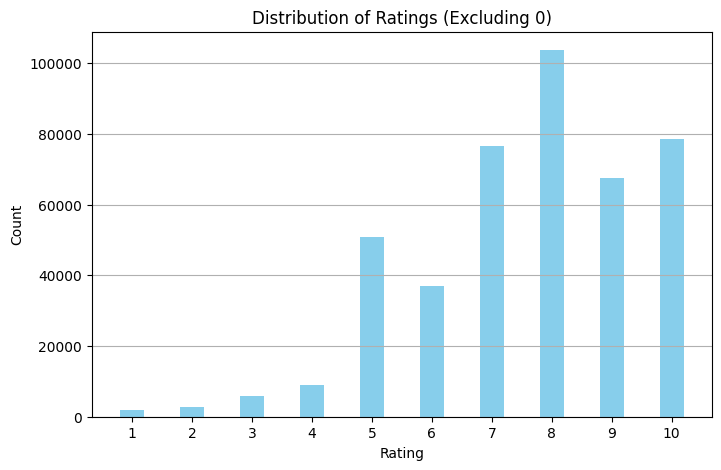


With added columns:


,user_id,isbn,rating,r_seq_user,r_seq_book,r_cat
0,276725,034545104X,0,1,1,not_rated
1,276726,0155061224,5,1,1,mid
2,276727,0446520802,0,1,1,not_rated
3,276729,052165615X,3,1,1,low
4,276729,0521795028,6,2,1,mid
5,276733,2080674722,0,1,1,not_rated
6,276736,3257224281,8,1,1,high
7,276737,0600570967,6,1,1,mid



r_cat distribution (count, percent):


,count,percent
r_cat,,
high,180193,15.67
low,14900,1.30
mid,87898,7.64
not_rated,716109,62.28
very_high,146151,12.71
very_low,4529,0.39


Saved: /book_rec_project/data/interim/ratings_cleaned.csv (1,149,780 rows)


In [11]:
print("Cleaning ratings.csv -> ratings_cleaned.csv\n")
ratings_path = Path("../data/raw/ratings.csv")
if not ratings_path.exists():
    raise FileNotFoundError(f"{ratings_path} not found")

df_ratings = pd.read_csv(ratings_path, sep=",", low_memory=False)
print(f"Current columns in ratings.csv: {df_ratings.columns.tolist()}")
ratings_clean = apply_column_map(df_ratings, ratings_map)
print(f"Columns after applying main_books_map: {ratings_clean.columns.tolist()}")

# print("Sample of cleaned ratings data:")
# display(ratings_clean.head())

# dist of ratings other than 0
rating_counts = ratings_clean[ratings_clean['rating'] != 0]['rating'].value_counts().sort_index()
print("Distribution of ratings (excluding 0):") 
print(rating_counts)
# histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.bar(rating_counts.index, rating_counts.values, width=0.4, color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings (Excluding 0)')
plt.xticks(rating_counts.index)
plt.grid(axis='y')
plt.show()

# Preserve original file order (row index) so we can derive both sequences deterministically
ratings_clean = ratings_clean.reset_index().rename(columns={'index': 'raw_file_order'})

# Do NOT globally sort by user_id here — keep original file order as the canonical ordering.
# Compute per-user rating sequence (1-based) according to file order
ratings_clean['r_seq_user'] = ratings_clean.groupby('user_id').cumcount() + 1

# Compute per-book (isbn) rating sequence (1-based) according to file order
ratings_clean['r_seq_book'] = ratings_clean.groupby('isbn').cumcount() + 1

# r_cat: explicit value-based buckets (0 -> not_rated; 1-2,3-4,5-6,7-8,9-10)
def _rating_to_cat(v):
    if pd.isna(v) or int(v) == 0:
        return 'not_rated'
    v = int(v)
    if v <= 2:
        return 'very_low'    # 1-2
    if v <= 4:
        return 'low'         # 3-4
    if v <= 6:
        return 'mid'         # 5-6
    if v <= 8:
        return 'high'        # 7-8
    return 'very_high'      # 9-10

ratings_clean['r_cat'] = ratings_clean['rating'].apply(_rating_to_cat)

ratings_final = ratings_clean.drop(columns = ['raw_file_order'])

print("\nWith added columns:")
display(ratings_final.head(8))

# r_cat distribution with counts + percentage
print("\nr_cat distribution (count, percent):")
r_cat_counts = ratings_final['r_cat'].value_counts().sort_index()
r_cat_pct = ratings_final['r_cat'].value_counts(normalize=True).sort_index().mul(100).round(2)
r_cat_dist = pd.concat([r_cat_counts, r_cat_pct], axis=1)
r_cat_dist.columns = ['count', 'percent']
display(r_cat_dist)

# Persist cleaned ratings
ratings_out = interim_dir / "ratings_cleaned.csv"
ratings_rel = _compute_relative_target_dir(ratings_out)
ratings_final.to_csv(ratings_out, index=False, encoding='utf-8')
print(f"Saved: {ratings_rel} ({len(ratings_final):,} rows)")

In [9]:
# dist of ratings other than 0 per book
print("\nDistribution of ratings per book (excluding 0), overall, with count and percentage:")
ratings_nonzero = ratings_clean[ratings_clean['rating'] != 0]
book_rating_counts = ratings_nonzero.groupby('isbn')['rating'].value_counts().unstack(fill_value=0)
book_rating_pct = book_rating_counts.div(book_rating_counts.sum(axis=1), axis=0).mul(100).round(2)
book_rating_dist = pd.concat([book_rating_counts, book_rating_pct.add_suffix('_percent')], axis=1)
display(book_rating_dist.head(10))
book_rating_dist.describe()


Distribution of ratings per book (excluding 0), overall, with count and percentage:


rating,1,2,3,4,5,6,7,8,9,10,1_percent,2_percent,3_percent,4_percent,5_percent,6_percent,7_percent,8_percent,9_percent,10_percent
isbn,,,,,,,,,,,,,,,,,,,,
0330299891,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
0375404120,0,0,1,0,0,0,0,0,0,0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9022906116,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
#6612432,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
'9607092910',0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
)416195113,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
)452273056,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
)553267833,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
",.0330486187",0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


rating,1,2,3,4,5,6,7,8,9,10,1_percent,2_percent,3_percent,4_percent,5_percent,6_percent,7_percent,8_percent,9_percent,10_percent
count,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000,185973.000000
mean,0.009518,0.014835,0.032241,0.047878,0.274094,0.198545,0.411119,0.557801,0.363176,0.422696,0.464006,0.692124,1.485436,2.218595,13.764434,8.985329,17.795726,22.578466,14.134389,17.881255
std,0.198736,0.229698,0.285406,0.285058,0.791262,0.678312,1.268475,1.853509,1.443461,1.664809,6.200524,7.533441,10.922870,13.315770,31.535377,25.760504,34.312269,37.317640,31.023617,34.816597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.670000,33.330000,0.000000,12.500000
max,74.000000,82.000000,87.000000,58.000000,88.000000,66.000000,115.000000,188.000000,179.000000,158.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000



Distribution of number of ratings per book (excluding 0):


count    185973.000000
mean          2.331903
std           6.834667
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         707.000000
dtype: float64

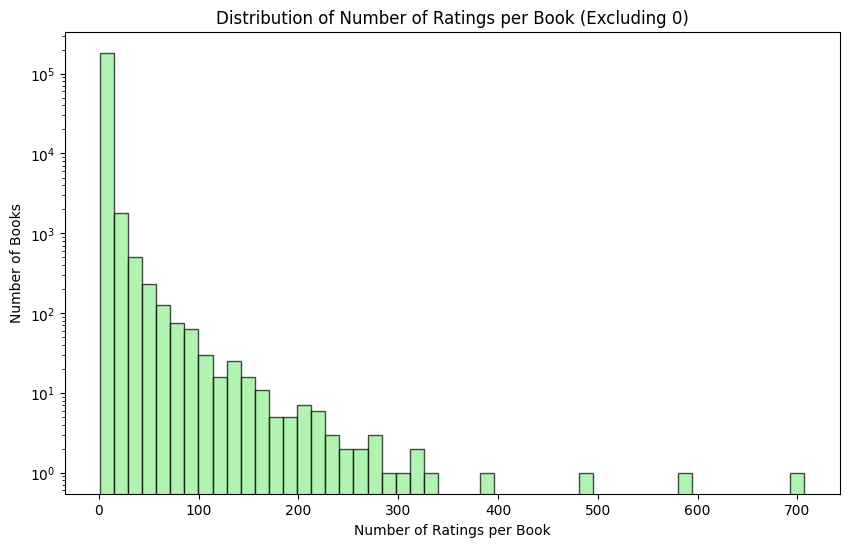

In [18]:
# Distribution of number of ratings per book (excluding 0)
ratings_per_book = ratings_nonzero.groupby('isbn').size()
print("\nDistribution of number of ratings per book (excluding 0):")
display(ratings_per_book.describe())
# plot by proportion
plt.figure(figsize=(10,6))
plt.hist(ratings_per_book, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Ratings per Book')
plt.ylabel('Number of Books')
plt.title('Distribution of Number of Ratings per Book (Excluding 0)')
plt.yscale('log')  # Log scale for better visibility    
plt.show()

**Note:** Pareto distribution is very typical in real networks i.e., a small number of users provide most ratings, while many users provide few ratings.

## New version of users data with reading and critic profiling

In [5]:
print("\nAdded columns: r_seq, r_cat, head:")
display(ratings_clean.head(8))

# r_cat distribution with counts + percentage
print("\nr_cat distribution (count, percent):")
r_cat_counts = ratings_clean['r_cat'].value_counts().sort_index()
r_cat_pct = ratings_clean['r_cat'].value_counts(normalize=True).sort_index().mul(100).round(2)
r_cat_dist = pd.concat([r_cat_counts, r_cat_pct], axis=1)
r_cat_dist.columns = ['count', 'percent']
display(r_cat_dist)

# ------------------ Added: per-user reading & critic profiling ------------------
# Compute per-user rating counts and basic stats (consider only explicit ratings > 0)
rated = ratings_clean[ratings_clean['rating'] > 0].copy()
user_stats = rated.groupby('user_id').agg(
    total_ratings = ('rating', 'size'),
    mean_rating = ('rating', 'mean'),
    median_rating = ('rating', 'median'),
    std_rating = ('rating', 'std')
).fillna({'std_rating': 0})

# Category counts per user (including 'not_rated' if present)
cat_counts = ratings_clean.groupby('user_id')['r_cat'].value_counts().unstack(fill_value=0)

# Build profile dataframe
user_profile = user_stats.copy()
user_profile['total_books'] = ratings_clean.groupby('user_id')['rating'].count()  # includes zeros
user_profile['cnt_very_low'] = cat_counts.get('very_low', 0)
user_profile['cnt_very_high'] = cat_counts.get('very_high', 0)
user_profile['cnt_not_rated'] = cat_counts.get('not_rated', 0)

# percentages (guard divide-by-zero)
user_profile['pct_very_low'] = (user_profile['cnt_very_low'] / user_profile['total_ratings']).fillna(0)
user_profile['pct_very_high'] = (user_profile['cnt_very_high'] / user_profile['total_ratings']).fillna(0)

# Reader level based on number of explicit ratings (tunable thresholds)
def _reader_level(n):
    if pd.isna(n) or int(n) == 0:
        return 'no_ratings'
    n = int(n)
    if n <= 5:
        return 'very_light'
    if n <= 20:
        return 'light'
    if n <= 50:
        return 'moderate'
    if n <= 200:
        return 'heavy'
    return 'very_heavy'

user_profile['reader_level'] = user_profile['total_ratings'].apply(_reader_level)
# dist of reader levels
print("\nReader level distribution (count, percent):")
reader_level_counts = user_profile['reader_level'].value_counts().sort_index()
reader_level_pct = user_profile['reader_level'].value_counts(normalize=True).sort_index().mul(100).round(2)
reader_level_dist = pd.concat([reader_level_counts, reader_level_pct], axis=1)
reader_level_dist.columns = ['count', 'percent']
display(reader_level_dist)

def _critic_profile(row, min_count=3, low_thr=4.0, high_thr=7.0, std_low=1.5, std_high=2.5):
    """
    Classify users by mean + std of explicit ratings (1-10 scale).
    - no_ratings_recorded: has events but zero explicit ratings
    - insufficient_ratings: fewer than min_count explicit ratings
    - polarized: high std and mean in the middle (user uses extremes)
    - lenient_varied / demanding_varied: high std but mean near an extreme
    - lenient / demanding / balanced: low std (consistent raters)
    Thresholds std_low/std_high are tunable.
    """
    total_r = int(row.get('total_ratings', 0)) if not pd.isna(row.get('total_ratings', 0)) else 0
    total_books = int(row.get('total_books', 0)) if not pd.isna(row.get('total_books', 0)) else 0

    # No explicit ratings but has book events
    if total_r == 0 and total_books > 0:
        return 'no_ratings_recorded'
    # Not enough data
    if total_r < min_count:
        return 'insufficient_ratings'

    mean = row.get('mean_rating', np.nan)
    std = row.get('std_rating', np.nan)
    if pd.isna(mean) or pd.isna(std):
        return 'insufficient_ratings'

    high_variability = std >= std_high
    low_variability = std <= std_low

    # High variability + mean near center => polarized
    if high_variability and (mean > low_thr and mean < high_thr):
        return 'polarized'
    # High variability + mean towards extremes => varied but biased
    if high_variability and mean >= high_thr:
        return 'lenient_varied'
    if high_variability and mean <= low_thr:
        return 'demanding_varied'

    # Low variability -> consistent behaviour
    if low_variability:
        if mean >= high_thr:
            return 'lenient'
        if mean <= low_thr:
            return 'demanding'
        return 'balanced'

    # Medium variability fallback: use mean to decide
    if mean >= high_thr:
        return 'lenient'
    if mean <= low_thr:
        return 'demanding'
    return 'balanced'

user_profile['critic_profile'] = user_profile.apply(_critic_profile, axis=1)

# Dist of critic_profiles 
print("\nCritic profile distribution (count, percent):")
critic_profile_counts = user_profile['critic_profile'].value_counts().sort_index()
critic_profile_pct = user_profile['critic_profile'].value_counts(normalize=True).sort_index().mul(100).round(2)
critic_profile_dist = pd.concat([critic_profile_counts, critic_profile_pct], axis=1)
critic_profile_dist.columns = ['count', 'percent']
display(critic_profile_dist)

# Keep / expose useful cols
user_profile = user_profile.reset_index()[[
    'user_id', 'total_ratings', 'total_books', 'reader_level',
    'critic_profile', 'mean_rating', 'median_rating', 'std_rating',
    'cnt_very_low', 'cnt_very_high', 'cnt_not_rated', 'pct_very_low', 'pct_very_high'
]]

print("\nSample user_profile (top 8):")
display(user_profile.head(8))

# example of polarized user:
polarized_users = user_profile[user_profile['critic_profile'] == 'polarized']
if not polarized_users.empty:
    example_user = polarized_users.iloc[0]['user_id']
    user_ratings = ratings_clean[ratings_clean['user_id'] == example_user]
    print(f"\nExample polarized user_id={example_user} ratings:")
    display(user_ratings.sort_values('rating'))
print("\nA few polarizes users:\n")
display(polarized_users.head())

display(user_profile[['user_id','total_ratings','mean_rating','std_rating','critic_profile']].sample(100))
#  Merge profiles into users dataframe (prefer geolocated cleaned users if available)
users_out = None
try:
    users_path_try = Path("../data/interim/users_cleaned_geoloc.csv")
    if users_path_try.exists():
        users_df = pd.read_csv(users_path_try, index_col=0, encoding='utf-8')
        # safer merge: reset index, merge on user_id, keep result as a normal DataFrame
        merged_df = users_df.reset_index().merge(user_profile, on='user_id', how='left')
        users_out = merged_df  # plain DataFrame, avoid set_index(...) that caused the warning
        merged_name = "users_cleaned_geoloc_profiled.csv"
    elif Path("../data/interim/users_cleaned.csv").exists():
        users_df = pd.read_csv("../data/interim/users_cleaned.csv", index_col=0, encoding='utf-8')
        merged_df = users_df.reset_index().merge(user_profile, on='user_id', how='left')
        users_out = merged_df
        merged_name = "users_cleaned_profiled.csv"
    else:
        users_out = None
        print("Couldn't find users_cleaned_geoloc.csv or users_cleaned.csv; skipping merge into users.")
except Exception as e:
    print(f"Warning merging profiles into users: {e}")
    users_out = None

print(f"\nCurrent columns: {users_out.columns.tolist() if users_out is not None else 'N/A'}")
filter_order = ['user_id', 'age', 'age_group', 'is_synthetic_age', 'gender', 'location', 'country', 'latitude', 'longitude', 'is_synthetic_location', 'reader_level', 'critic_profile', 'total_ratings', 'total_books', 'mean_rating', 'median_rating', 'std_rating']
final_user = users_out[filter_order].reset_index(drop=True) if users_out is not None else None
print(f"\nFinal columns after reordering: {final_user.columns.tolist() if final_user is not None else 'N/A'}")
print("Sample of final merged users with profiles:")
display(final_user.head() if final_user is not None else "N/A")

# Final check of users that have ratings data, distribution:
if final_user is not None:
    users_with_ratings = final_user.index.isin(ratings_clean['user_id'].unique())
    final_user['has_ratings'] = users_with_ratings
    print("\nDistribution of users with ratings vs without and percentage:")
    ratings_status_counts = final_user['has_ratings'].value_counts().sort_index()
    ratings_status_pct = final_user['has_ratings'].value_counts(normalize=True).sort_index().mul(100).round(2)
    ratings_status_dist = pd.concat([ratings_status_counts, ratings_status_pct], axis=1)
    ratings_status_dist.columns = ['count', 'percent']
    display(ratings_status_dist)

    # Save \merged user profile
    profile_out_path = interim_dir / merged_name
    final_user.to_csv(profile_out_path, index=False, encoding='utf-8')
    print(f"\nSaved user profile table: {_compute_relative_target_dir(profile_out_path)} ({len(user_profile):,} rows)")


Added columns: r_seq, r_cat, head:


,user_id,isbn,rating,r_seq,r_cat
0,2,0195153448,0,1,not_rated
1,7,034542252,0,1,not_rated
2,8,0002005018,5,1,mid
3,8,0060973129,0,2,not_rated
4,8,080652121X,0,3,not_rated
5,8,1567407781,6,4,mid
6,8,0887841740,5,5,mid
7,8,1881320189,7,6,high



r_cat distribution (count, percent):


,count,percent
r_cat,,
high,180193,15.67
low,14900,1.30
mid,87898,7.64
not_rated,716109,62.28
very_high,146151,12.71
very_low,4529,0.39



Reader level distribution (count, percent):


,count,percent
reader_level,,
heavy,1151,1.48
light,8498,10.92
moderate,2226,2.86
very_heavy,144,0.19
very_light,65786,84.55



Critic profile distribution (count, percent):


,count,percent
critic_profile,,
balanced,5983,7.69
demanding,107,0.14
demanding_varied,32,0.04
insufficient_ratings,55237,70.99
lenient,14857,19.10
lenient_varied,712,0.92
polarized,877,1.13



Sample user_profile (top 8):


,user_id,total_ratings,total_books,reader_level,critic_profile,mean_rating,median_rating,std_rating,cnt_very_low,cnt_very_high,cnt_not_rated,pct_very_low,pct_very_high
0,8,7,18,light,balanced,5.571429,5.0,0.786796,0,0,11,0.0,0.0
1,9,1,3,very_light,insufficient_ratings,6.000000,6.0,0.000000,0,0,2,0.0,0.0
2,10,1,2,very_light,insufficient_ratings,6.000000,6.0,0.000000,0,0,1,0.0,0.0
3,12,1,1,very_light,insufficient_ratings,10.000000,10.0,0.000000,0,1,0,0.0,1.0
4,14,3,4,very_light,balanced,5.333333,5.0,0.577350,0,0,1,0.0,0.0
5,16,1,2,very_light,insufficient_ratings,9.000000,9.0,0.000000,0,1,1,0.0,1.0
6,17,4,7,very_light,balanced,5.250000,5.5,1.707825,0,0,3,0.0,0.0
7,19,1,1,very_light,insufficient_ratings,7.000000,7.0,0.000000,0,0,0,0.0,0.0



Example polarized user_id=69 ratings:


,user_id,isbn,rating,r_seq,r_cat
80,69,0773670637,0,1,not_rated
82,69,0770428827,0,3,not_rated
85,69,0312970242,0,6,not_rated
83,69,0676973655,3,4,low
84,69,0617683993,6,5,mid
81,69,1853260053,8,2,high



A few polarizes users:



,user_id,total_ratings,total_books,reader_level,critic_profile,mean_rating,median_rating,std_rating,cnt_very_low,cnt_very_high,cnt_not_rated,pct_very_low,pct_very_high
19,69,3,6,very_light,polarized,5.666667,6.0,2.516611,0,0,3,0.00,0.000000
47,165,3,5,very_light,polarized,6.000000,5.0,2.645751,0,1,2,0.00,0.333333
239,899,5,12,very_light,polarized,6.000000,7.0,2.915476,1,1,7,0.20,0.200000
808,2906,3,9,very_light,polarized,6.333333,7.0,3.055050,0,1,6,0.00,0.333333
973,3542,4,11,very_light,polarized,5.000000,4.0,3.559026,1,1,7,0.25,0.250000


,user_id,total_ratings,mean_rating,std_rating,critic_profile
66534,238753,2,7.500000,3.535534,insufficient_ratings
28395,101101,3,7.666667,2.516611,lenient_varied
61154,219386,2,5.000000,0.000000,insufficient_ratings
7474,27300,3,7.000000,2.645751,lenient_varied
23894,85164,2,6.000000,0.000000,insufficient_ratings
...,...,...,...,...,...
18099,64320,2,5.500000,3.535534,insufficient_ratings
10460,37149,1,8.000000,0.000000,insufficient_ratings
25963,92635,1,8.000000,0.000000,insufficient_ratings
18181,64591,1,9.000000,0.000000,insufficient_ratings



Current columns: ['index', 'user_id', 'age', 'age_group', 'is_synthetic_age', 'gender', 'location', 'country', 'latitude', 'longitude', 'is_synthetic_location', 'total_ratings', 'total_books', 'reader_level', 'critic_profile', 'mean_rating', 'median_rating', 'std_rating', 'cnt_very_low', 'cnt_very_high', 'cnt_not_rated', 'pct_very_low', 'pct_very_high']

Final columns after reordering: ['user_id', 'age', 'age_group', 'is_synthetic_age', 'gender', 'location', 'country', 'latitude', 'longitude', 'is_synthetic_location', 'reader_level', 'critic_profile', 'total_ratings', 'total_books', 'mean_rating', 'median_rating', 'std_rating']
Sample of final merged users with profiles:


,user_id,age,age_group,is_synthetic_age,gender,location,country,latitude,longitude,is_synthetic_location,reader_level,critic_profile,total_ratings,total_books,mean_rating,median_rating,std_rating
0,1,28,adult_25_34,True,male,"nyc, new york, usa",United States,39.783730,-100.445882,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,18,young_adult_18_24,False,non-binary,"stockton, california, usa",United States,39.783730,-100.445882,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,60,senior_gt_60,True,male,"moscow, yukon territory, russia",Russian Federation,64.686314,97.745306,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,17,juvenile_12_17,False,male,"porto, v.n.gaia, portugal",Portugal,39.662165,-8.135352,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,43,adult_35_49,True,female,"farnborough, hants, united kingdom",United Kingdom,54.702354,-3.276575,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Distribution of users with ratings vs without and percentage:


,count,percent
has_ratings,,
False,173575,62.24
True,105283,37.76



Saved user profile table: /book_rec_project/data/interim/users_cleaned_geoloc_profiled.csv (77,805 rows)
